In [17]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from itertools import combinations

from ast import literal_eval
from scipy import stats
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [18]:
# Required data paths
DATA_FOLDER = "../../data"
ESTIMATES_FOLDER = DATA_FOLDER + "/estimates_emnlp2024"
CROSSVAL_RESULTS_FOLDER = "crossvalidation_results"
RUNTIME_RESULTS_FOLDER = "runtime_results"
FIGURES_FOLDER = "figures"


# Variance and Runtime

### Load variance and runtime statistics

In [19]:
# Utility functions

def parse_path_sampling(path):
    """
    Parse the path of an output file to extract the parameters used.
    """
    path = os.path.basename(path)
    path = path.split('_')
    return {
        'model': path[0],
        'n_samples': int(path[1][1:]),                    # e.g., n512
        'max_tokens': int(path[2][7:]),                   # e.g., ntokens10
        'seed': int(path[3][4:]),                         # e.g., seed0
        'temperature': float(f"{path[4][-1]}.{path[5]}")  # e.g., temp1_0
    }

def get_list(s):
    """
    Parse a string representation of a list to a list.
    """
    try:
        return literal_eval(s)
    except SyntaxError:
        return list(map(float, s[1:-1].split()))
    except ValueError:
        return list(map(float, s[1:-1].split()))



In [20]:
# Load variance and bootstrap estimates
all_dirs = glob.glob(os.path.join(ESTIMATES_FOLDER, "*"))

li = []
for dir in all_dirs:
    if 'exact' in dir:
        continue
    try:
        df = pd.read_csv(os.path.join(dir, 'summary_stats.csv'), index_col=None, header=0)
        df = df.assign(**parse_path_sampling(dir))
    except FileNotFoundError:
        continue
    li.append(df)

summary_stats = pd.concat(li, axis=0, ignore_index=True)
# Discard estimates of sequence-level metrics obtained with a single token
summary_stats = summary_stats[~(
    (summary_stats["max_tokens"] == 1) & 
    (summary_stats["metric"].isin(['sequence_entropy', 'expected_seq_decontextualised']))
)]
# Distcard estimates of next-symbol measures obtained with more than one token
summary_stats = summary_stats[~(
    (summary_stats["max_tokens"] > 1) & 
    (~summary_stats["metric"].isin(['sequence_entropy', 'expected_seq_decontextualised']))
)]


# Split resamples from summary_stats
resamples = summary_stats.copy()
resamples.drop(columns=["mean", "variance"], inplace=True)
summary_stats.drop(columns=["resamples"], inplace=True)

# Load runtime estimates
li = []
for dir in all_dirs:
    if 'exact' in dir:
        continue
    try:
        df = pd.read_csv(os.path.join(dir, 'runtimes.csv'), index_col=None, header=0)
        df = df.assign(**parse_path_sampling(dir))
    except FileNotFoundError:
        continue
    
    li.append(df)

runtimes = pd.concat(li, axis=0, ignore_index=True)
# Discard estimates of sequence-level metrics obtained with a single token
runtimes = runtimes[~(
    (runtimes["max_tokens"] == 1) & 
    (runtimes["metric"].isin(['sequence_entropy', 'expected_seq_decontextualised']))
)]
# Distcard estimates of next-symbol measures obtained with more than one token
runtimes = runtimes[~(
    (runtimes["max_tokens"] > 1) & 
    (~runtimes["metric"].isin(['sequence_entropy', 'expected_seq_decontextualised']))
)]

runtimes["runtime"] = runtimes["runtime"].apply(get_list)
runtimes = runtimes.explode("runtime", ignore_index=True)



### Stimulus-level variance: Coefficient of variation

In [5]:
def compute_cv(means, variances):
    """
    Compute the coefficient of variation (CV) given the mean and variance.
    """
    try:
        means = np.array(get_list(means))
        variances = np.array(get_list(variances))
        stdevs = np.sqrt(variances)
        cv = stdevs / means
        return cv
    except:
        return np.nan
    
summary_stats["CV"] = summary_stats.apply(lambda x: compute_cv(x["mean"], x["variance"]), axis=1)
summary_stats = summary_stats.explode("CV", ignore_index=True).drop(columns=['mean', 'variance']).dropna()


/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_91523/91986144.py:9: RuntimeWarning: invalid value encountered in divide
  cv = stdevs / means


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


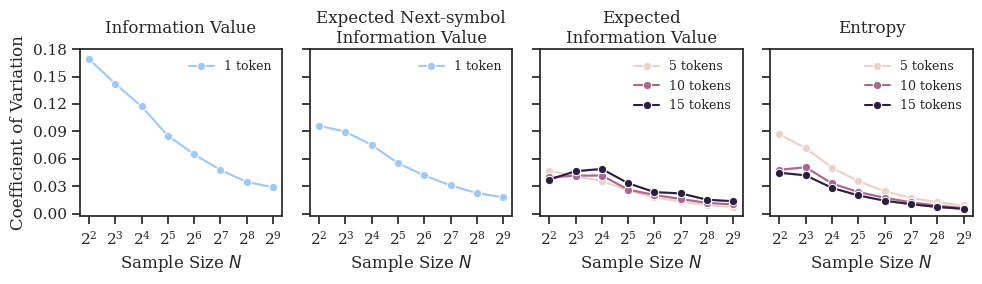

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


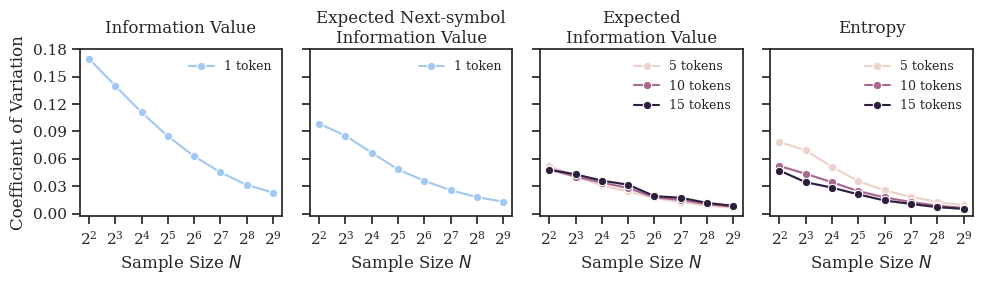

In [6]:
# Plot style settings
sns.set_theme(style="ticks", palette="pastel")
sns.set_style({'font.family':'serif'})

# Metrics requiring MC estimation
mc_metric_names = {
    'sequence_entropy': 'Entropy',
    'expected_seq_decontextualised': 'Expected\nInformation Value',
    'decontextualised': 'Information Value',
    'expected_decontextualised': 'Expected Next-symbol\nInformation Value'
}

# Plot the coefficient of variation over the number of samples
for lm in ['gpt2-small', 'neo-125m']:
    fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
    for i, metric in enumerate(['decontextualised', 'expected_decontextualised', 'expected_seq_decontextualised', 'sequence_entropy']):
        sns.lineplot(data=summary_stats[
            (summary_stats.temperature == 1) &
            (summary_stats.model == lm) &
            (summary_stats.metric == metric)
        ], x="n_samples", y="CV", hue="max_tokens", marker="o", ax=axs[i], errorbar=('ci', 0.95), legend=True)
        
        # set title with vertical alignment = center
        axs[i].set_title(mc_metric_names[metric], pad=15, verticalalignment='center')
        axs[i].set_xlabel("Sample Size $N$")
        axs[i].set_ylabel("Coefficient of Variation")
        axs[i].set_xscale('log', base=2)
        axs[i].set_xticks([4, 8, 16, 32, 64, 128, 256, 512])
        axs[i].set_yticks(np.arange(0, 0.181, 0.03))
        
        handles, labels = axs[i].get_legend_handles_labels()
        legend_labels = [f"{label} tokens" if label in ["5", "10", "15"] else f"{label} token" for label in labels]
        axs[i].legend(handles=handles, labels=legend_labels, title="", loc='upper right', ncol=1, frameon=False, fontsize=9)

    plt.tight_layout()
    plt.savefig(f'{FIGURES_FOLDER}/variance_over_nsamples_{lm}.eps', bbox_inches='tight')
    plt.show()


### Correlation between resamples

In [7]:
# Cross-correlation Parameters

N_RESAMPLES_CORRELATION = 100

In [8]:
def get_list_of_lists(s):
    """
    Parse a string representation of a list of lists to a list of lists.
    """
    def _get_sublist(s):
        try:
            return literal_eval(s)
        except ValueError:
            return list(map(float, s.split(", ")))
    try:
        return literal_eval(s)
    except ValueError:
        return list(map(_get_sublist, s[2:-2].split("], [")))

resamples['resamples'] = resamples['resamples'].apply(get_list_of_lists)

In [9]:
# Rearrange resamples 
bootstrapped_scores = []
for group, group_df in tqdm(resamples.groupby(['metric', 'model', 'n_samples', 'max_tokens', 'id'])):
    mat = np.asarray(group_df['resamples'].values[0])
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            bootstrapped_scores.append({
                'metric': group[0],
                'model': group[1],
                'n_samples': group[2],
                'max_tokens': group[3],
                'doc_id': group[4],
                'word_id': i,
                'resample_id': j,
                'estimate': mat[i, j]
            })

bootstrapped_scores = pd.DataFrame(bootstrapped_scores)

  0%|          | 0/42640 [00:00<?, ?it/s]

In [10]:
correlations = []
for group, group_df in tqdm(bootstrapped_scores.groupby(['metric', 'model', 'n_samples', 'max_tokens'])):
    
    # Create matrix of bootstrapped estimates: (n_docs * n_words) x n_resamples
    mat = []
    for resample_id in group_df.resample_id.unique():
        mat.append(group_df[group_df.resample_id == resample_id].estimate.values)
    mat = np.asarray(mat).T

    # Compute correlations between resampled estimates
    for i, j in combinations(range(mat.shape[1]), 2):

        array_i, array_j = mat[:, i], mat[:, j]
        nas = np.logical_or(np.isnan(array_i), np.isnan(array_j))
        array_i, array_j = array_i[~nas], array_j[~nas]

        corr, _ = stats.pearsonr(array_i, array_j)
        correlations.append({
            'metric': group[0],
            'model': group[1],
            'n_samples': group[2],
            'max_tokens': group[3],
            'corr_metric': 'pearson',
            'correlation': corr
        })
        corr, _ = stats.spearmanr(array_i, array_j)
        correlations.append({
            'metric': group[0],
            'model': group[1],
            'n_samples': group[2],
            'max_tokens': group[3],
            'corr_metric': 'spearman',
            'correlation': corr
        })

correlations_df = pd.DataFrame(correlations)

  0%|          | 0/208 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


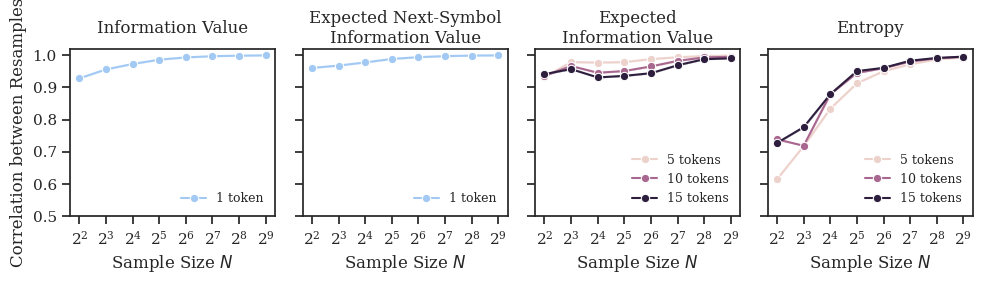

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


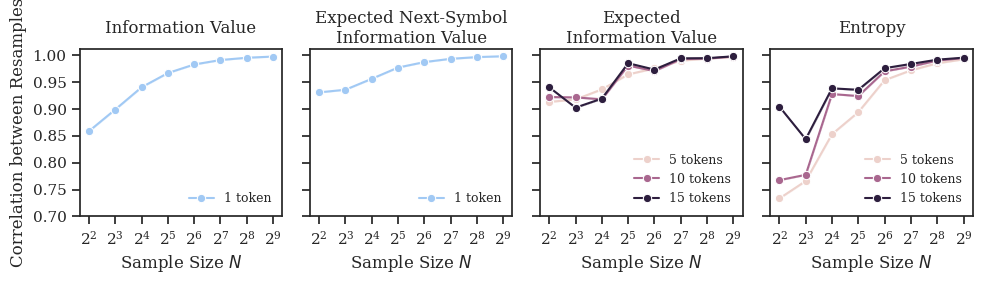

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


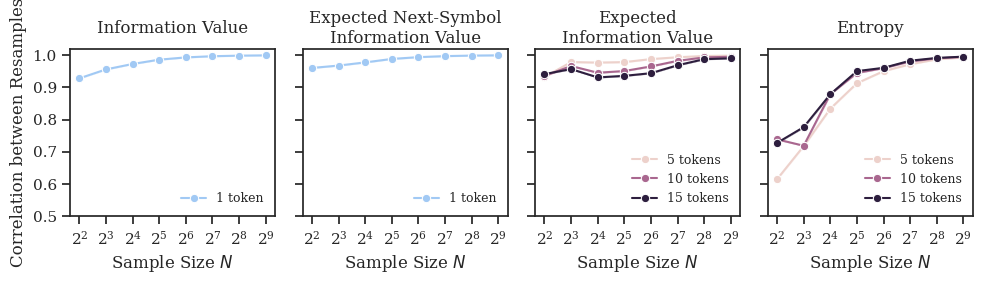

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


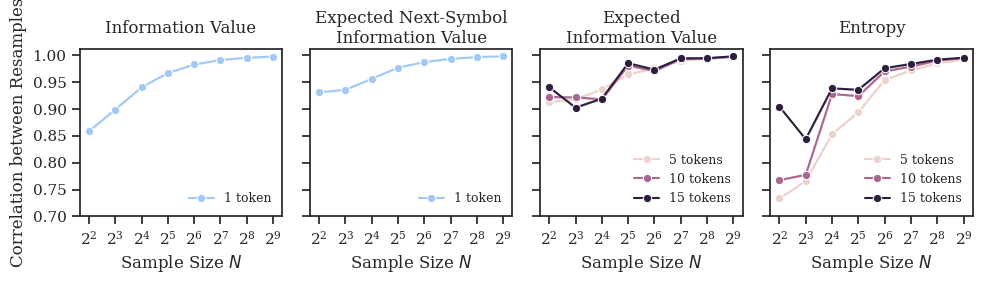

In [11]:
# Plot style settings
sns.set_theme(style="ticks", palette="pastel")
sns.set_style({'font.family':'serif'})

# Metrics requiring MC estimation
mc_metric_names = {
    'sequence_entropy': 'Entropy',
    'expected_seq_decontextualised': 'Expected\nInformation Value',
    'decontextualised': 'Information Value',
    'expected_decontextualised': 'Expected Next-Symbol\nInformation Value'
}

# Plot the coefficient of variation over the number of samples
for corr_metric in ['pearson', 'spearman']:
    for lm in ['gpt2-small', 'neo-125m']:
        fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
        for i, metric in enumerate(['decontextualised', 'expected_decontextualised', 'expected_seq_decontextualised', 'sequence_entropy']):
            sns.lineplot(data=correlations_df[
                    (correlations_df.model == lm) &
                    (correlations_df.metric == metric) &
                    (correlations_df.corr_metric == 'pearson')
                ], 
                x="n_samples", y="correlation", hue="max_tokens", marker="o", ax=axs[i], errorbar=('ci', 0.95))
            axs[i].set_title(mc_metric_names[metric], pad=15, verticalalignment='center')
            axs[i].set_xlabel("Sample Size $N$")
            axs[i].set_ylabel("Correlation between Resamples")
            axs[i].set_xscale('log', base=2)
            axs[i].set_xticks([4, 8, 16, 32, 64, 128, 256, 512])
            if lm == 'gpt2-small':
                axs[i].set_yticks(np.arange(0.5, 1.01, 0.1))
            else:
                axs[i].set_yticks(np.arange(0.7, 1.01, 0.05))
            handles, labels = axs[i].get_legend_handles_labels()

            legend_labels = [f"{label} tokens" if label in ["5", "10", "15"] else f"{label} token" for label in labels]
            axs[i].legend(handles=handles, labels=legend_labels, title="", loc='lower right', ncol=1, frameon=False, fontsize=9)
            
        plt.tight_layout()
        plt.savefig(f'{FIGURES_FOLDER}/{corr_metric}_crosscorrelation_over_nsamples_{lm}.eps', bbox_inches='tight')
        plt.show()


### Runtime

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


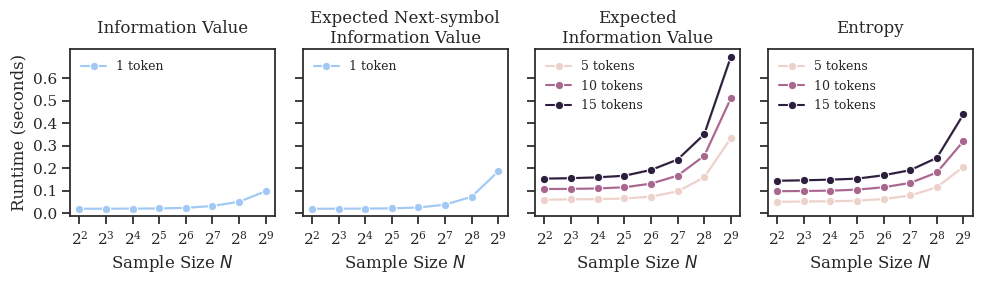

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


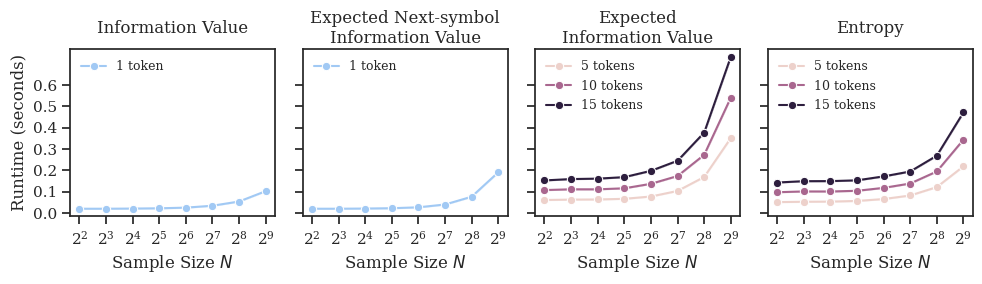

In [12]:
# Plot style settings
sns.set_theme(style="ticks", palette="pastel")
sns.set_style({'font.family':'serif'})

# Metrics requiring MC estimation
mc_metric_names = {
    'sequence_entropy': 'Entropy',
    'expected_seq_decontextualised': 'Expected\nInformation Value',
    'decontextualised': 'Information Value',
    'expected_decontextualised': 'Expected Next-symbol\nInformation Value'
}

# Plot the runtime over the number of tokens
for lm in ['gpt2-small', 'neo-125m']:
    fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
    for i, metric in enumerate(['decontextualised', 'expected_decontextualised', 'expected_seq_decontextualised', 'sequence_entropy']):
        sns.lineplot(data=runtimes[
            (runtimes.temperature == 1) &
            (runtimes.model == lm) &
            (runtimes.metric == metric)
            ], 
            x="n_samples", y="runtime", hue="max_tokens", marker="o", ax=axs[i], errorbar=('ci', 0.95))
        axs[i].set_title(mc_metric_names[metric], pad=15, verticalalignment='center')
        axs[i].set_xlabel("Sample Size $N$")
        axs[i].set_ylabel("Runtime (seconds)")
        axs[i].set_xscale('log', base=2)
        axs[i].set_xticks([4, 8, 16, 32, 64, 128, 256, 512])
        axs[i].set_yticks(np.arange(0, 0.7, 0.1))

        handles, labels = axs[i].get_legend_handles_labels()
        legend_labels = [f"{label} tokens" if label in ["5", "10", "15"] else f"{label} token" for label in labels]
        axs[i].legend(handles=handles, labels=legend_labels, title="", loc='upper left', ncol=1, frameon=False, fontsize=9)
   
    plt.tight_layout()
    plt.savefig(f'{FIGURES_FOLDER}/runtime_over_nsamples_{lm}.eps', bbox_inches='tight')
    plt.show()


### Coefficient of variation, correlation between resamples, and runtime in a single plot.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


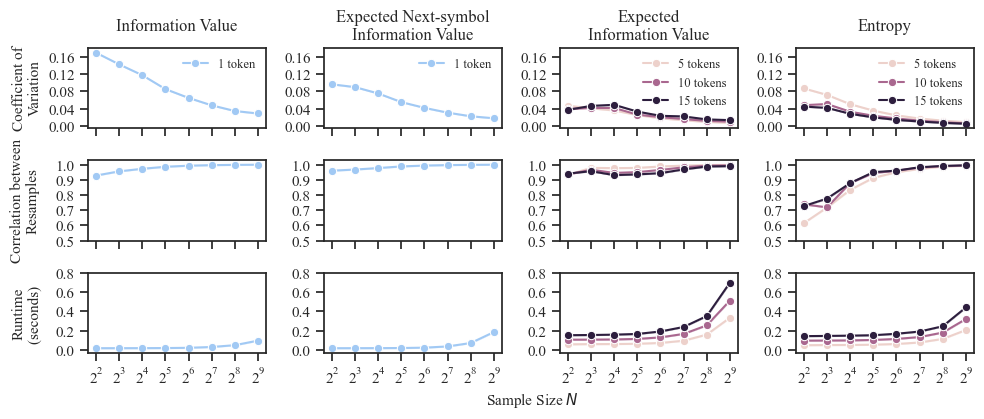

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


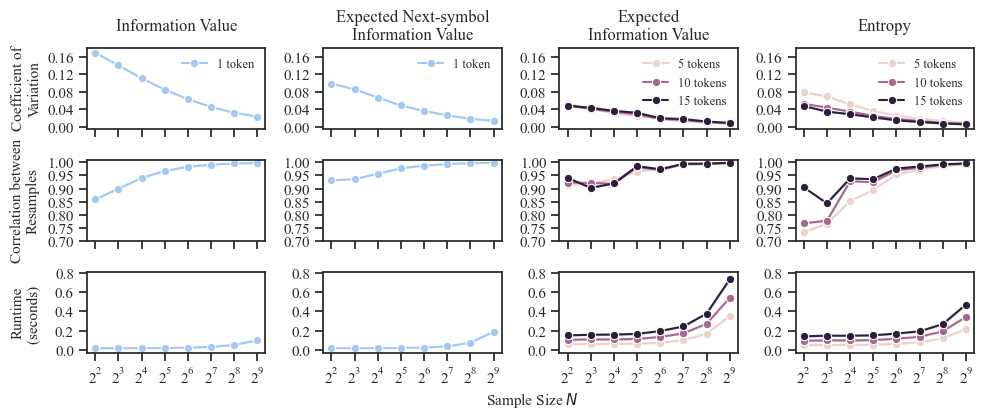

In [22]:
# Plot style settings
sns.set_theme(style="ticks", palette="pastel")
sns.set_style("ticks", {'font.family': 'Times New Roman'})

# Metrics requiring MC estimation
mc_metric_names = {
    'sequence_entropy': 'Entropy',
    'expected_seq_decontextualised': 'Expected\nInformation Value',
    'decontextualised': 'Information Value',
    'expected_decontextualised': 'Expected Next-symbol\nInformation Value'
}

# Plot the coefficient of variation, cross-correlation, and runtime over the number of samples
for lm in ['gpt2-small', 'neo-125m']:
    fig, axs = plt.subplots(3, 4, figsize=(10, 4.5), sharex=True)
    for i, metric in enumerate(['decontextualised', 'expected_decontextualised', 'expected_seq_decontextualised', 'sequence_entropy']):
        sns.lineplot(data=summary_stats[
            (summary_stats.temperature == 1) &
            (summary_stats.model == lm) &
            (summary_stats.metric == metric)
        ], x="n_samples", y="CV", hue="max_tokens", marker="o", ax=axs[0, i], errorbar=('ci', 0.95), legend=True)
        sns.lineplot(data=correlations_df[
            (correlations_df.model == lm) &
            (correlations_df.metric == metric) &
            (correlations_df.corr_metric == 'pearson')
        ], 
        x="n_samples", y="correlation", hue="max_tokens", marker="o", ax=axs[1, i], errorbar=('ci', 0.95), legend=False)
        sns.lineplot(data=runtimes[
            (runtimes.temperature == 1) &
            (runtimes.model == lm) &
            (runtimes.metric == metric)
            ], 
            x="n_samples", y="runtime", hue="max_tokens", marker="o", ax=axs[2, i], errorbar=('ci', 0.95), legend=False)
        
        axs[0, i].set_title(mc_metric_names[metric], pad=15, verticalalignment='center', fontsize=12)
        axs[0, i].set_xlabel("Sample Size $N$")
        if i == 0:
            axs[0, i].set_ylabel("Coefficient of\nVariation", fontsize=11, labelpad=15, verticalalignment='center')
        else:
            axs[0, i].set_ylabel("")
        axs[0, i].set_xscale('log', base=2)
        axs[0, i].set_xticks([4, 8, 16, 32, 64, 128, 256, 512])
        axs[0, i].set_ylim(-0.005, 0.181)
        axs[0, i].set_yticks(np.arange(0, 0.181, 0.04))
        
        axs[1, i].set_xlabel("Sample Size $N$")
        if i == 0:
            labelpad = 22 if lm == 'gpt2-small' else 16
            axs[1, i].set_ylabel("Correlation between\nResamples", fontsize=11, labelpad=labelpad, verticalalignment='center')
        else:
            axs[1, i].set_ylabel("")
        axs[1, i].set_xscale('log', base=2)
        axs[1, i].set_xticks([4, 8, 16, 32, 64, 128, 256, 512])
        if lm == 'gpt2-small':
            axs[1, i].set_ylim(0.5, 1.03)
            axs[1, i].set_yticks(np.arange(0.5, 1.01, 0.1))
        else:
            axs[1, i].set_ylim(0.7, 1.01)
            axs[1, i].set_yticks(np.arange(0.7, 1.01, 0.05))
        
        axs[2, i].set_xlabel("")
        if i == 0:
            axs[2, i].set_ylabel("Runtime\n(seconds) ", fontsize=11, labelpad=21, verticalalignment='center')
        else:
            axs[2, i].set_ylabel("")

        axs[2, i].set_xscale('log', base=2)
        axs[2, i].set_xticks([4, 8, 16, 32, 64, 128, 256, 512])
        if lm == 'gpt2-small':
            axs[2, i].set_ylim(-0.03, 0.801)
            axs[2, i].set_yticks(np.arange(0, 0.801, 0.2))
        else:
            axs[2, i].set_ylim(-0.03, 0.81)
            axs[2, i].set_yticks(np.arange(0, 0.81, 0.2))

        handles, labels = axs[0, i].get_legend_handles_labels()
        legend_labels = [f"{label} tokens" if label in ["5", "10", "15"] else f"{label} token" for label in labels]
        axs[0, i].legend(handles=handles, labels=legend_labels, title="", loc='upper right', ncol=1, frameon=False, fontsize=9)
        
        # else:
        #     axs[0, i].get_legend().remove()
        #     axs[1, i].get_legend().remove()
        #     axs[2, i].get_legend().remove()

    # set a title at the bottom, shared by all subplots
    fig.suptitle("Sample Size $N$", ha='center', va='bottom', fontsize=11, x=0.54, y=-0.01)
    plt.tight_layout()
    plt.savefig(f'{FIGURES_FOLDER}/variance_crosscorrelation_runtime_over_nsamples_{lm}.eps', bbox_inches='tight')
    plt.show()


# Correlation between measures

### Load responsive and anticipatory measures estimated for Aligned

In [3]:
# MC Estimation Parameters
N_SAMPLES = 512
N_TOKENS = 5

# Load estimates
estimates = pd.read_csv(f"{DATA_FOLDER}/psyling/aligned_with_estimates_23july.csv")


### _Figure 1_ and _Figure 2_: Pearson and Spearman correlation 

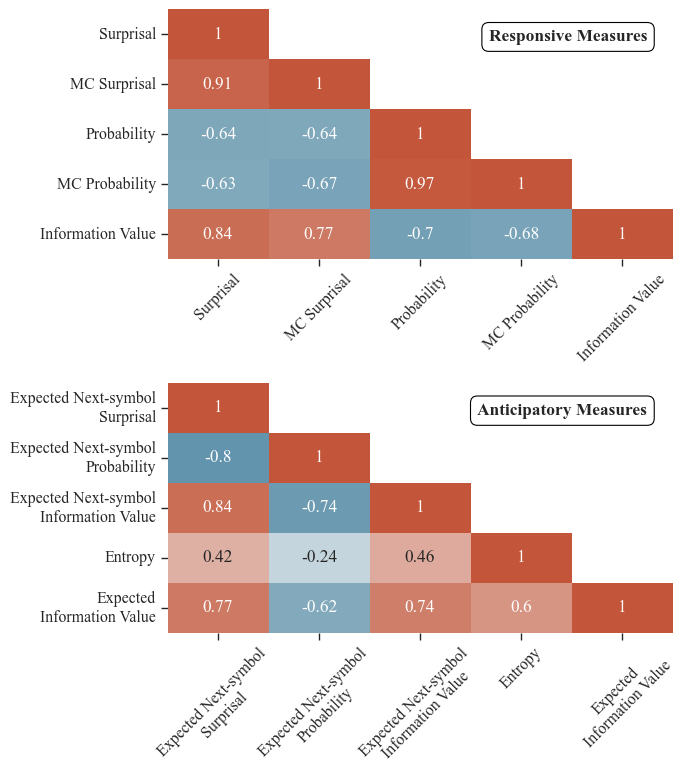

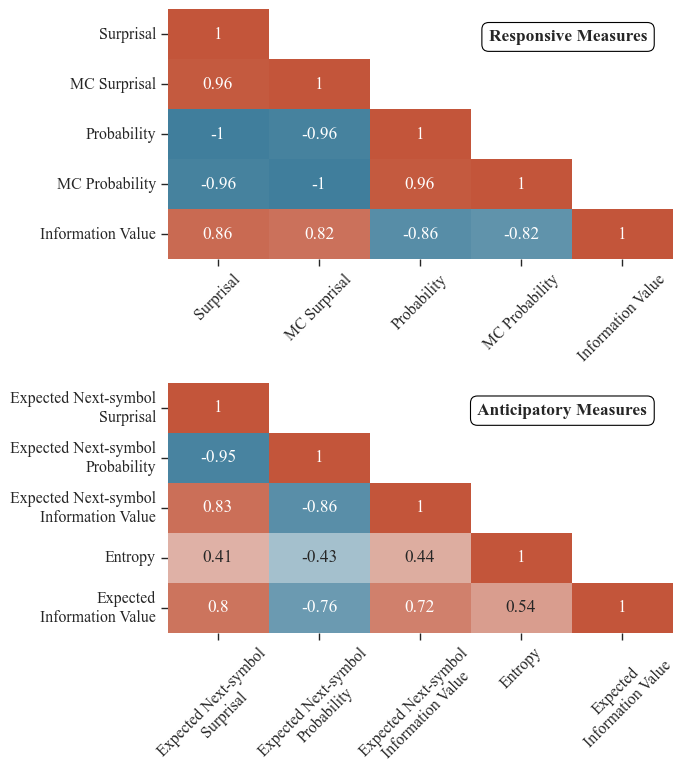

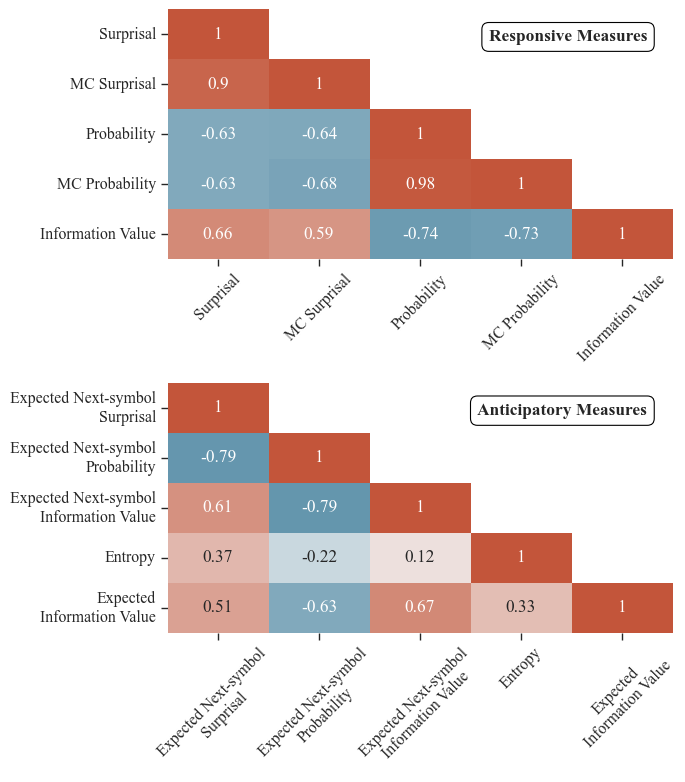

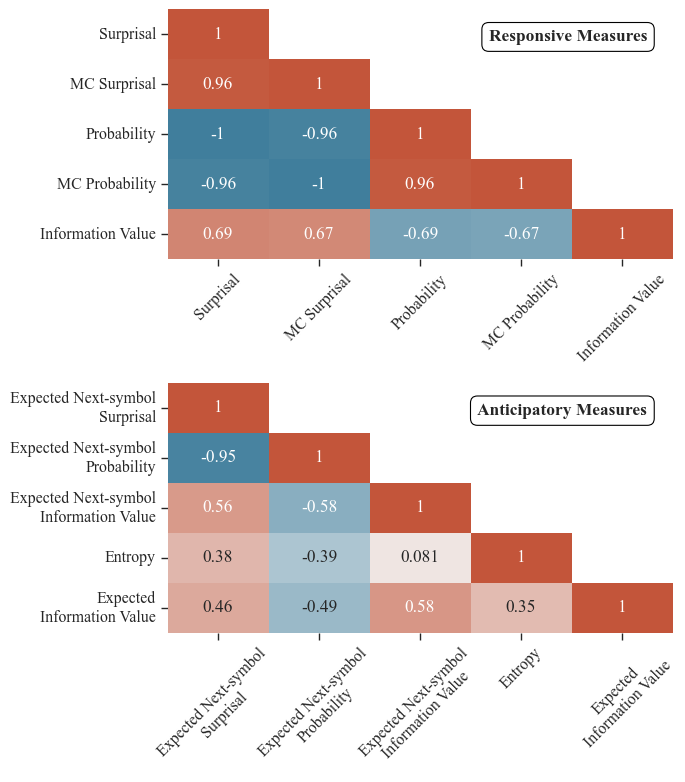

In [4]:
# Plot style settings
sns.set_theme(style="ticks", context="paper", font_scale=1.3)
sns.set_style("ticks", {'font.family': 'Times New Roman'})
cmap = sns.diverging_palette(230, 20, as_cmap=True)

for lm in ['gpt2-small', 'neo-125m']:
    lm_ = lm.replace('-', '_')
    # From dataframe fields to human-readable labels
    corr_metric_labels = {
        f'prob_{lm_}': 'Probability',
        f'surprisal_{lm_}': 'Surprisal',
        f'decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'Information Value',
        f'when_first_token_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'MC Probability',
        f'neg_log2_when_first_token_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'MC Surprisal',
        f'expected_prob_{lm_}': 'Expected Next-symbol\nProbability',
        f'entropy_{lm_}': 'Expected Next-symbol\nSurprisal',
        f'sequence_entropy_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'Entropy',
        f'expected_decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'Expected Next-symbol\nInformation Value',
        f'expected_seq_decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'Expected\nInformation Value',
    }

    # Plot heatmap of correlation matrix for Pearson and Spearman correlation
    for corr_measure in ['pearson', 'spearman']:

        # One figure with two subplots: responsive measures and anticipatory measures
        fig, axes = plt.subplots(2, 1, figsize=(7, 8))

        # Compute correlation matrix for responsive measures
        correlation_matrix = estimates[[
            f'surprisal_{lm_}', 
            f'neg_log2_when_first_token_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0', 
            f'prob_{lm_}', 
            f'when_first_token_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0', 
            f'decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0'
        ]].corr(corr_measure)
        
        # Rename rows and columns
        correlation_matrix = correlation_matrix.rename(index=corr_metric_labels, columns=corr_metric_labels)
        
        # Create mask to hide upper triangle
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
        
        # Plot heatmap
        sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1, mask=mask, ax=axes[0], cbar=False)

        # Reposition x labels
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45) #, ha='center', va='center_baseline', position=(0, -0.03))

        # Label first heatmap as "Responsive Measures"
        axes[0].text(0.95, 0.92, 'Responsive Measures', verticalalignment='top', horizontalalignment='right', transform=axes[0].transAxes, fontweight='bold', rotation=0, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))


        # Compute correlation matrix for anticipatory measures
        correlation_matrix = estimates[[
            f'entropy_{lm_}', 
            f'expected_prob_{lm_}', 
            f'expected_decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0',
            f'sequence_entropy_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0',
            f'expected_seq_decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0', 
        ]].corr(corr_measure)

        # Rename rows and columns
        correlation_matrix = correlation_matrix.rename(index=corr_metric_labels, columns=corr_metric_labels)

        # Create mask to hide upper triangle
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

        # Plot heatmap
        sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1, mask=mask, ax=axes[1], cbar=False)

        # Reposition x labels
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45) #, ha='center', va='center_baseline', position=(0, -0.03))

        # Label second heatmap as "Anticipatory Measures"
        axes[1].text(0.95, 0.92, 'Anticipatory Measures', verticalalignment='top', horizontalalignment='right', transform=axes[1].transAxes, fontweight='bold', rotation=0, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))

        plt.tight_layout()
        plt.savefig(f"{FIGURES_FOLDER}/correlation_matrix_{corr_measure}_{N_SAMPLES}samples_{N_TOKENS}tokens_{lm}.eps", bbox_inches='tight')
        plt.show()

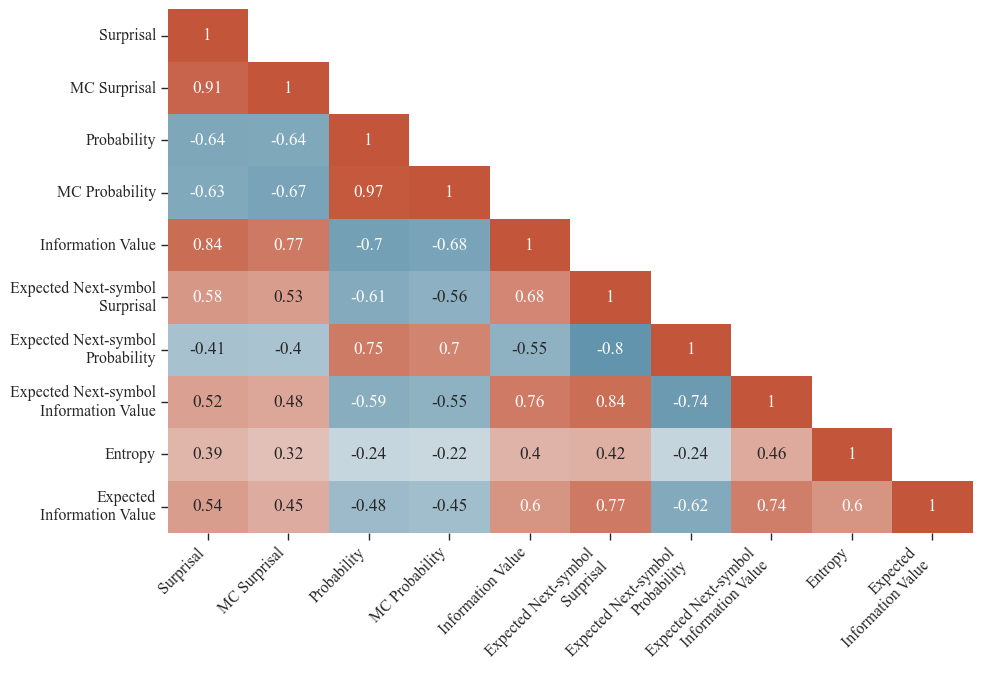

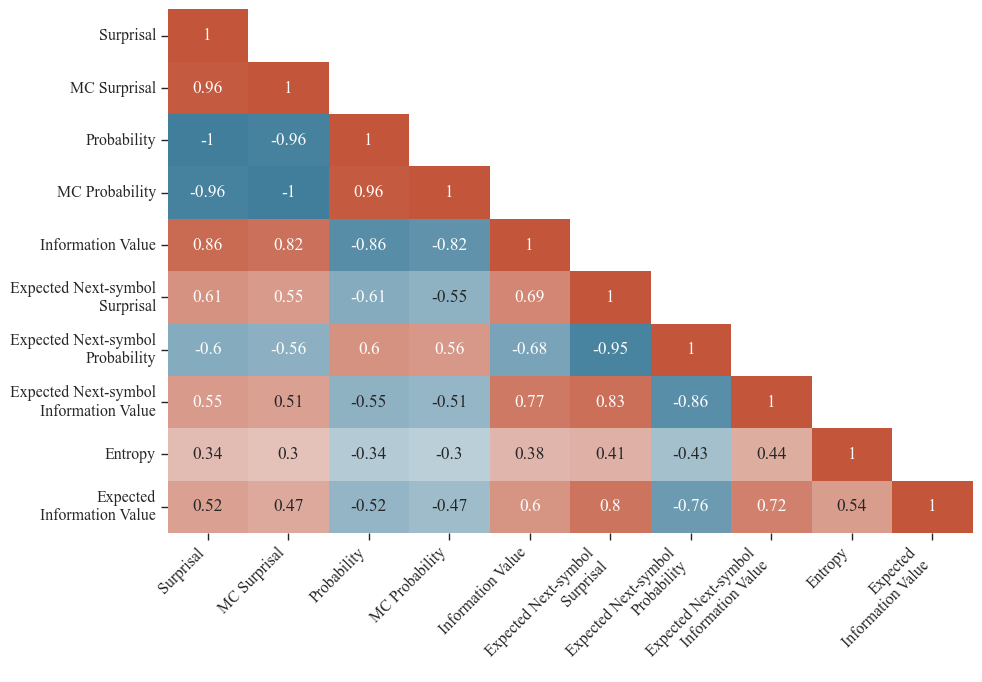

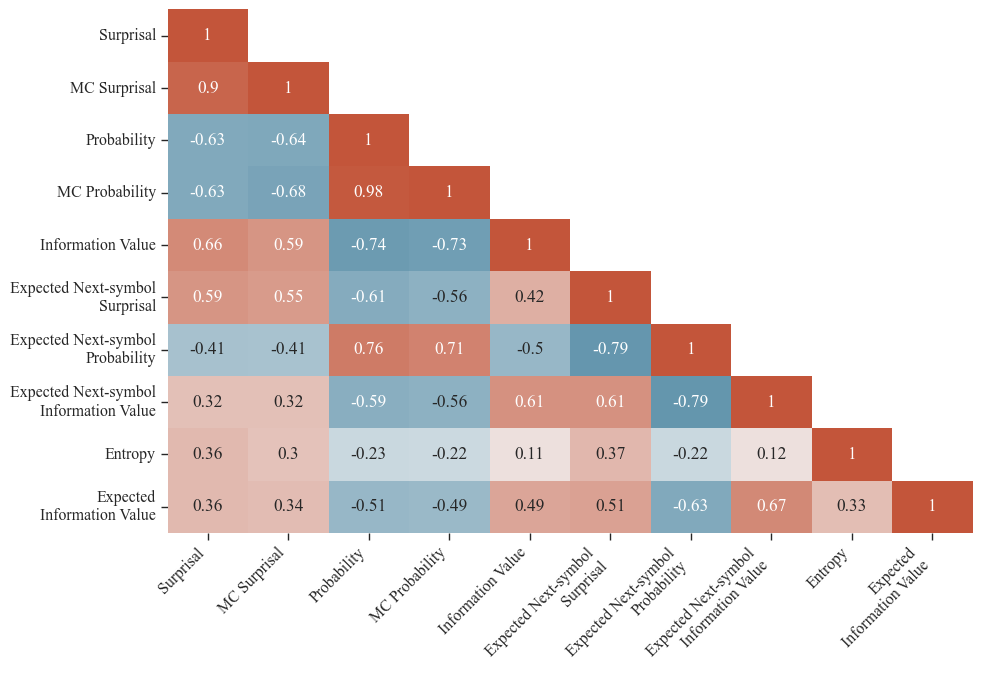

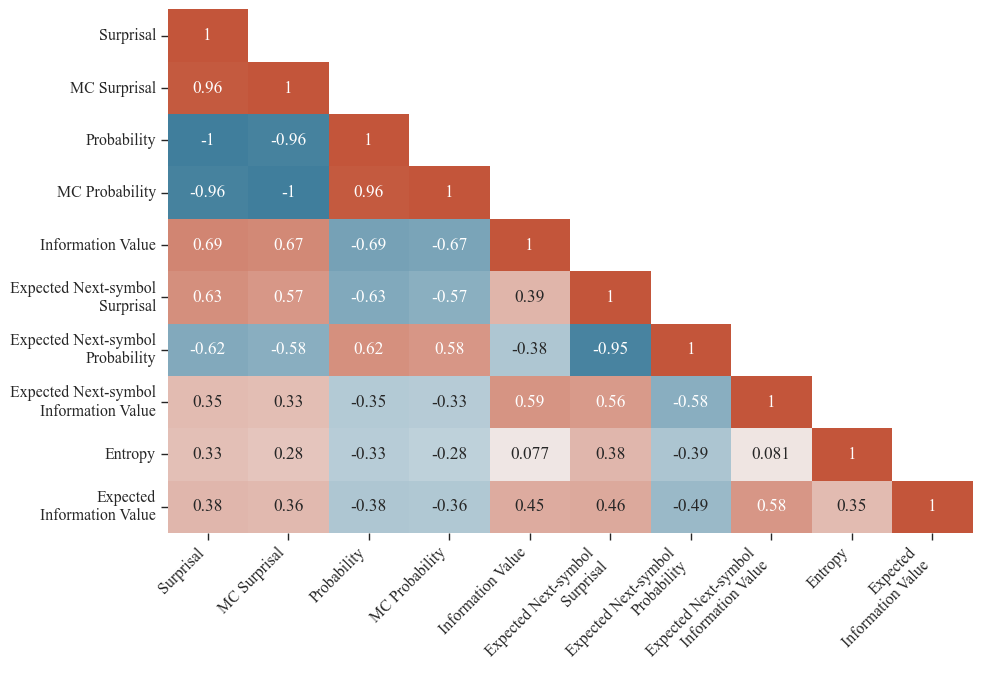

In [16]:
# Plot style settings
sns.set_theme(style="ticks", context="paper", font_scale=1.3)
sns.set_style("ticks", {'font.family': 'Times New Roman'})
cmap = sns.diverging_palette(230, 20, as_cmap=True)

for lm in ['gpt2-small', 'neo-125m']:
    lm_ = lm.replace('-', '_')
    # From dataframe fields to human-readable labels
    corr_metric_labels = {
        f'prob_{lm_}': 'Probability',
        f'surprisal_{lm_}': 'Surprisal',
        f'decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'Information Value',
        f'when_first_token_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'MC Probability',
        f'neg_log2_when_first_token_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'MC Surprisal',
        f'expected_prob_{lm_}': 'Expected Next-symbol\nProbability',
        f'entropy_{lm_}': 'Expected Next-symbol\nSurprisal',
        f'sequence_entropy_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'Entropy',
        f'expected_decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'Expected Next-symbol\nInformation Value',
        f'expected_seq_decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0': 'Expected\nInformation Value',
    }

    # Plot heatmap of correlation matrix for Pearson and Spearman correlation
    for corr_measure in ['pearson', 'spearman']:

        # One figure with two subplots: responsive measures and anticipatory measures
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Compute correlation matrix for responsive measures
        correlation_matrix = estimates[[
            f'surprisal_{lm_}', 
            f'neg_log2_when_first_token_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0', 
            f'prob_{lm_}', 
            f'when_first_token_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0', 
            f'decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0',
            f'entropy_{lm_}', 
            f'expected_prob_{lm_}', 
            f'expected_decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0',
            f'sequence_entropy_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0',
            f'expected_seq_decontextualised_{lm_}_{N_SAMPLES}_{N_TOKENS}_1_0'
        ]].corr(corr_measure)
        
        # Rename rows and columns
        correlation_matrix = correlation_matrix.rename(index=corr_metric_labels, columns=corr_metric_labels)
        
        # Create mask to hide upper triangle
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
        
        # Plot heatmap
        sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1, mask=mask, ax=ax, cbar=False)

        # Reposition x labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') #, va='center_baseline', position=(0, -0.03))

        # Label first heatmap as "Responsive Measures"
        # axes[0].text(0.95, 0.92, 'Responsive Measures', verticalalignment='top', horizontalalignment='right', transform=axes[0].transAxes, fontweight='bold', rotation=0, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))

        plt.tight_layout()
        plt.savefig(f"{FIGURES_FOLDER}/correlation_matrix_all_measures_{corr_measure}_{N_SAMPLES}samples_{N_TOKENS}tokens_{lm}.eps", bbox_inches='tight')
        plt.show()

# Psycholinguistic predictive power

In [15]:
# MC Estimation Parameters
N_SAMPLES = 512
N_TOKENS = 5
LM = 'gpt2-small'
LM_ = LM.replace("-", "_")

# Permutation Test Parameters
N_PERMUTATIONS = 10000

In [16]:
# Define names and labels of predicted variables and predictors

# Predicted variables
y_labels_judgements = {
    'cloze_p_smoothed': 'Cloze probability',
    'entropy': 'Cloze entropy',
    'rating_mean': 'Predictability',
}
y_labels_rt = {
    'RTfirstfix': 'First-fixation RT',
    'RTfirstpass': 'First-pass RT',
    'RTrightbound': 'Right-bounded RT',
    'self_paced_reading_time': 'Self-paced RT',
}
y_labels_erp = {
    'ELAN': 'ELAN',
    'LAN': 'LAN',
    'N400': 'N400',
    'EPNP': 'EPNP',
    'P600': 'P600',
    'PNP': 'PNP',
}
y_labels = {**y_labels_judgements, **y_labels_rt, **y_labels_erp}

# Predictors
x_labels_responsive = {
    'surprisal': 'Surprisal',
    'prob': 'Probability',
    'decontextualised': 'Information Value',
}
x_labels_anticipatory = {
    'entropy': 'ENS Surprisal',
    'expected_prob': 'ENS Probability',
    'expected_decontextualised': 'ENS Information Value',
    'expected_seq_decontextualised': 'Exp. Information Value',
    'sequence_entropy': 'Entropy'
}
x_longlabels_anticipatory = {
    'entropy': 'Expected Next-symbol Surprisal',
    'expected_prob': 'Expected Next-symbol Probability',
    'expected_decontextualised': 'Expected Next-symbol Information Value',
    'expected_seq_decontextualised': 'Expected Information Value',
    'sequence_entropy': 'Entropy'
}
x_labels = {**x_labels_responsive, **x_labels_anticipatory}


## Linking function analysis


### _Figure 4_: Probability and surprisal against human cloze probabilities and predictability judgments

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


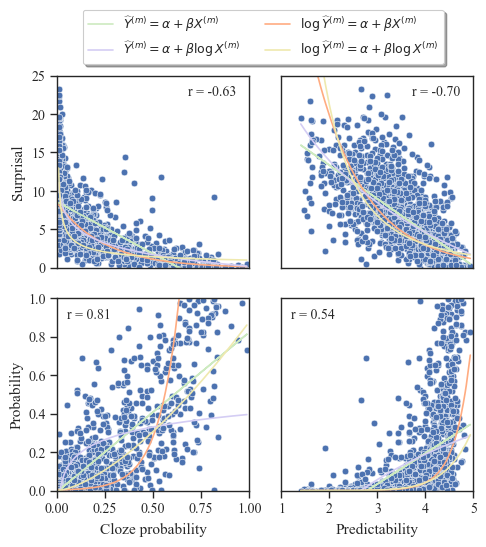

In [346]:
# Plot style settings
sns.set_theme(style="ticks", context="paper", font_scale=1.15)
sns.set_style("ticks", {'font.family': 'Times New Roman'})
color = sns.color_palette("light:b", 10)[-1]

fig, ax = plt.subplots(2, 2, figsize=(5, 5))

lines = []

# Plot probability and surprisal against human cloze probabilities and predictability judgments, 
# with Pearson (r) and Spearman (ρ) correlation coefficients, linear and log-linear regression lines
for i, x in enumerate([f'surprisal_{LM_}', f'prob_{LM_}']):
    for j, y in enumerate(['cloze_p_smoothed', 'rating_mean']):

        # Plot the estimates
        sns.scatterplot(data=estimates, x=y, y=x, ax=ax[i, j], color=color)
        
        # Set labels only for the leftmost column and bottom row
        if i == 1:
            ax[i, j].set_xlabel(y_labels[y], labelpad=5)
        else:
            ax[i, j].set_xlabel('')
        if j == 0:
            labelpad = 3 if x == f'prob_{LM_}' else 5
            ax[i, j].set_ylabel(x_labels[x.replace(f"_{LM_}", "")], labelpad=labelpad)
        else:
            ax[i, j].set_ylabel('')

        # Set x and y limits according to the variable
        if y == 'cloze_p_smoothed':
            ax[i, j].set_xlim([0, 1])
        else:
            ax[i, j].set_xlim([1, 5])
        if x == f'prob_{LM_}':
            ax[i, j].set_ylim([0, 1])
        else:
            ax[i, j].set_ylim([0, 25])

        # Show x and y ticks only for the bottom and leftmost columns
        if j != 0:
            ax[i, j].set_yticks([])
        if i != 1:
            ax[i, j].set_xticks([])

        # Compute Pearson's correlation coefficients and p-values and add them to the plot
        r, p = stats.pearsonr(estimates[y], estimates[x])
        if x == f'prob_{LM_}':
            ax[i, j].text(
                0.05, 0.95, f'r = {r:.2f}',
                verticalalignment='top', horizontalalignment='left', transform=ax[i, j].transAxes, fontsize=10)
        else:
            ax[i, j].text(
                0.68, 0.95, f'r = {r:.2f}',
                verticalalignment='top', horizontalalignment='left', transform=ax[i, j].transAxes, fontsize=10)
            
        # Compute Spearman's correlation coefficients and p-values and add them to the plot
        # r, p = stats.spearmanr(estimates[y], estimates[x])
        # if x == f'prob_{LM_}':
        #     ax[i, j].text(
        #         0.04, 0.85, rf'$\rho$ = {r:.2f}',
        #         verticalalignment='top', horizontalalignment='left', transform=ax[i, j].transAxes, fontsize=10)
        # else:
        #     ax[i, j].text(
        #         0.67, 0.85, rf'$\rho$ = {r:.2f}',
        #         verticalalignment='top', horizontalalignment='left', transform=ax[i, j].transAxes, fontsize=10)
        
        # Fit a linear regression line
        X = estimates[y].values.reshape(-1, 1)
        Y = estimates[x]
        reg = LinearRegression().fit(X, Y)
        predicted_y = reg.predict(X)
        # # Clip
        # predicted_y = np.clip(predicted_y, a_min=0, a_max=None)
        # non_positive = predicted_y <= 0
        # Plot
        # line1, = ax[i, j].plot(X[~non_positive], predicted_y[~non_positive], color='brown')
        line1, = ax[i, j].plot(X, predicted_y, color='#cdeac0')
        
        # if x == f'surprisal_{LM_}' and y == 'cloze_p_smoothed':
        # Fit a log-linear regression line
        log_Y = np.log(Y)
        log_reg = LinearRegression().fit(X, log_Y)
        predicted_log_y = log_reg.predict(X)
        predicted_y = np.exp(predicted_log_y)
        # Sort values for a smooth line
        sorted_indices = np.argsort(X.flatten())
        X_sorted = X.flatten()[sorted_indices]
        predicted_y = predicted_y[sorted_indices]
        # # Clip
        # if x == f'prob_{LM_}' and y == 'cloze_p_smoothed':
        #     valid_indices = predicted_exp_y_sorted <= 1
        #     X_sorted = X_sorted[valid_indices]
        #     predicted_exp_y_sorted = predicted_exp_y_sorted[valid_indices]
        # Plot
        line2, = ax[i, j].plot(X_sorted, predicted_y, color='#ffac81')
        
        # Fit a linear-log regression line
        log_X = np.log(X)
        log_reg = LinearRegression().fit(log_X, Y)
        predicted_y = log_reg.predict(log_X)
        # Sort values for a smooth line
        sorted_indices = np.argsort(X.flatten())
        X_sorted = X.flatten()[sorted_indices]
        predicted_y_sorted = predicted_y[sorted_indices]
        # Plot 
        line3, = ax[i, j].plot(X_sorted, predicted_y_sorted, color='#d4cdf4')

        # Fit a log-log regression line
        log_X = np.log(X)
        log_Y = np.log(Y)
        log_reg = LinearRegression().fit(log_X, log_Y)
        predicted_log_y = log_reg.predict(log_X)
        predicted_y = np.exp(predicted_log_y)
        # Sort values for a smooth line
        sorted_indices = np.argsort(X.flatten())
        X_sorted = X.flatten()[sorted_indices]
        predicted_y = predicted_y[sorted_indices]
        # Plot
        line4, = ax[i, j].plot(X_sorted, predicted_y, color='#efe9ae')
          

#Legend with opacity
fig.legend([line1, line3, line2, line4], 
           [
               r'$\widehat{Y}^{(m)} = \alpha + \beta X^{(m)}$', 
               r'$\widehat{Y}^{(m)} = \alpha + \beta \log X^{(m)}$', 
               r'$\log \widehat{Y}^{(m)} = \alpha + \beta X^{(m)}$',
               r'$\log \widehat{Y}^{(m)} = \alpha + \beta \log X^{(m)}$'],
           loc='upper center', ncol=2, bbox_to_anchor=(0.54, 1.1), fontsize=9,
              markerscale=1.5, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig(f"{FIGURES_FOLDER}/surprisal_prob_vs_ratings_{LM_}.eps", bbox_inches='tight')
plt.show()

## Baseline regressor: control variables only

### Load cross-validation results

In [24]:
results_control_baseline_df = pd.read_csv(f"{CROSSVAL_RESULTS_FOLDER}/control_baseline_{LM_}_temp1_0_{N_SAMPLES}samples_{N_TOKENS}tokens_100x10fold.csv")

# Fill in missing values for exact metrics
results_control_baseline_df.nsamples = results_control_baseline_df.nsamples.fillna("")
results_control_baseline_df.ntokens = results_control_baseline_df.ntokens.fillna("")
results_control_baseline_df.temperature = results_control_baseline_df.temperature.fillna("")

# Consider only cross-validation results
results_control_baseline_df = results_control_baseline_df[results_control_baseline_df.fold != 'full']

# Consider only results for N_SAMPLES (when measure requires MC sampling)
results_control_baseline_df = results_control_baseline_df[results_control_baseline_df.nsamples.isin(['', N_SAMPLES])]

# Reorder columns
results_control_baseline_df = results_control_baseline_df[results_control_baseline_df.metric.isin(x_labels.keys())]
results_control_baseline_df = results_control_baseline_df[results_control_baseline_df.y.isin(y_labels.keys())]
results_control_baseline_df.metric = pd.Categorical(results_control_baseline_df.metric, categories=x_labels, ordered=True)
results_control_baseline_df = results_control_baseline_df.sort_values('metric')


### Significance testing: permutation tests

In [25]:
# Statistic
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)


# Permutation tests between R^2 of target vs. baseline regressors
pvals_baseline = {}
for y_k, y_v in y_labels.items():
    for m_k, m_v in x_labels.items():

        # Target regressor's R^2 (on the test set, across CV folds and random seeds)
        rsquared_target = results_control_baseline_df[
            (results_control_baseline_df.y == y_k) & (results_control_baseline_df.metric == m_k)
        ].rsquared_test.to_numpy()

        # Delta R^2 of target regressor vs. baseline (on the test set, across CV folds and random seeds)
        delta_rsquared = results_control_baseline_df[
            (results_control_baseline_df.y == y_k) & (results_control_baseline_df.metric == m_k)
        ].delta_rsquared_test.to_numpy()

        # Baseline regressor's R^2 (on the test set, across CV folds and random seeds)
        baseline_rsquared = rsquared_target - delta_rsquared
        
        # Permutation test
        # Null hypothesis: the target regressor's R^2 is not greater than the baseline regressor's R^2
        # Alternative hypothesis: the target regressor's R^2 is greater than the baseline regressor's R^2
        result = stats.permutation_test(
            (rsquared_target, baseline_rsquared), 
            statistic, vectorized=True, n_resamples=N_PERMUTATIONS, alternative='greater', permutation_type='samples', random_state=0
        )
        pvals_baseline[(y_v, m_v)] = result.pvalue


# Permutation tests between R^2 of target regressors
pvals_cross_metric = {}
for y_k, y_v in y_labels.items():
    for m1_k, m1_v in x_labels.items():
        for m2_k, m2_v in x_labels.items():

            if m1_k == m2_k:
                continue

            # R^2 of first target regressor (on the test set, across CV folds and random seeds)
            rsquared_m1 = results_control_baseline_df[
                (results_control_baseline_df.y == y_k) & (results_control_baseline_df.metric == m1_k)
            ].rsquared_test.to_numpy()
            
            # R^2 of second target regressor (on the test set, across CV folds and random seeds)
            rsquared_m2 = results_control_baseline_df[
                (results_control_baseline_df.y == y_k) & (results_control_baseline_df.metric == m2_k)
            ].rsquared_test.to_numpy()

            # Permutation test
            # Null hypothesis: the first target regressor's R^2 is not greater than the second target regressor's R^2
            # Alternative hypothesis: the first target regressor's R^2 is greater than the second target regressor's R^2
            result = stats.permutation_test(
                (rsquared_m1, rsquared_m2), 
                statistic, vectorized=True, n_resamples=N_PERMUTATIONS, alternative='greater', permutation_type='samples', random_state=0
            )
            pvals_cross_metric[(y_v, m1_v, m2_v)] = result.pvalue


/Users/mario/Library/Mobile Documents/com~apple~CloudDocs/mario/code/generalized-surprisal/.venv/lib/python3.9/site-packages/scipy/stats/_resampling.py:1114: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


### _Figure 3_: $\Delta_{R^2}$ of responsive measures for human cloze probabilities and predictability judgments

#### Verify significance

In [26]:
for y, m in pvals_baseline.keys():
    if y in ['Cloze probability', 'Predictability'] and m in ['Probability', 'Surprisal', 'Information Value']:
        print(f'{y} ~ {m}   p<0.0001 ?   {pvals_baseline[(y, m)] < 0.0001}')

Cloze probability ~ Surprisal   p<0.0001 ?   True
Cloze probability ~ Probability   p<0.0001 ?   True
Cloze probability ~ Information Value   p<0.0001 ?   True
Predictability ~ Surprisal   p<0.0001 ?   True
Predictability ~ Probability   p<0.0001 ?   True
Predictability ~ Information Value   p<0.0001 ?   True


In [27]:
for y in ['Cloze probability', 'Predictability']:
    for m1 in ['Probability', 'Surprisal', 'Information Value']:
        for m2 in ['Probability', 'Surprisal', 'Information Value']:
            if m1 == m2:
                continue
            if pvals_cross_metric[(y, m1, m2)] < 0.0001:
                print(f'{y}: {m1} > {m2}   {pvals_cross_metric[(y, m1, m2)]}')

Cloze probability: Probability > Surprisal   9.999000099990002e-05
Cloze probability: Probability > Information Value   9.999000099990002e-05
Cloze probability: Information Value > Surprisal   9.999000099990002e-05
Predictability: Surprisal > Probability   9.999000099990002e-05
Predictability: Surprisal > Information Value   9.999000099990002e-05


cloze_p_smoothed
surprisal
0.2099421140270115
0.053959024439606165

prob
0.4759067209810512
0.06880918094725874

decontextualised
0.232575305202565
0.07067668244235452

rating_mean
surprisal
0.30372494656132554
0.060295404853318885

prob
0.16133388686255637
0.039412554744316465

decontextualised
0.15548819052817955
0.05002150548093739



/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_91523/224696897.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(results_fig3[results_fig3.y == y][results_fig3.metric == m].delta_rsquared_test.mean())
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_91523/224696897.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(results_fig3[results_fig3.y == y][results_fig3.metric == m].delta_rsquared_test.std())
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_91523/224696897.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(results_fig3[results_fig3.y == y][results_fig3.metric == m].delta_rsquared_test.mean())
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_91523/224696897.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(results_fig3[results_fig3.y == y][results_fig3.metric == m].delta_rsquare

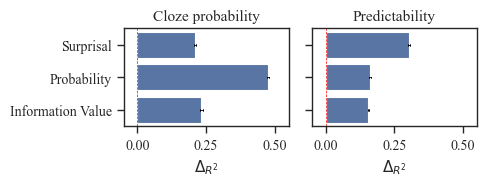

In [30]:
# Plot style settings
sns.set_theme(style='ticks', context='paper', font_scale=1.15)
sns.set_style("ticks", {'font.family': 'Times New Roman'})

# All measures show significant predictive power (p < 0.0001), so choose darker color for them.
color = sns.color_palette("light:b", 10)[-1]

# Collect results only for relevant predictors and predicted variables
relevant_metrics = ['surprisal', 'prob', 'decontextualised']
relevant_y = ['cloze_p_smoothed', 'rating_mean'] 
results_fig3 = results_control_baseline_df[results_control_baseline_df.metric.isin(relevant_metrics)]
results_fig3 = results_fig3[results_fig3.y.isin(relevant_y)] 
results_fig3.metric = pd.Categorical(results_fig3.metric, categories=relevant_metrics, ordered=True)
results_fig3 = results_fig3.sort_values('metric')

# Plot:
# The red dashed line corresponds to the regressor with baseline predictors. 
# Error bars represent 95% confidence intervals. 
# Same color for all measures, as all of them show significant predictive power (p < 0.0001).
fig, ax = plt.subplots(1, 2, figsize=(5, 2), sharey=True, sharex=True)

for i, y in enumerate(['cloze_p_smoothed', 'rating_mean']):
    # print the measure's delta_rsquared_test
    # print mean and stdev
    print(y)
    for m in relevant_metrics:
        print(m)
        print(results_fig3[results_fig3.y == y][results_fig3.metric == m].delta_rsquared_test.mean())
        print(results_fig3[results_fig3.y == y][results_fig3.metric == m].delta_rsquared_test.std())
        print()

    sns.barplot(
        data=results_fig3[results_fig3.y == y], 
        y='metric', 
        x='delta_rsquared_test', 
        ax=ax[i], 
        errorbar=('ci', 95),
        dodge=False, 
        err_kws={'linewidth': 0.6, 'color': 'black'},
        capsize=0.05,
        legend=False,
        label=r'$\Delta_{R^2}$' if i == 0 else '',
        color=color,
    )
    ax[i].set_xlabel(r'$\Delta_{R^2}$')
    ax[i].set_ylabel('')
    ax[i].set_yticklabels([x_labels[m] for m in results_fig3.metric.unique()], horizontalalignment='right') #, rotation=45, horizontalalignment='right')
    ax[i].set_title(y_labels[y])
    ax[i].set_xlim(-0.05, 0.55)

    # Baseline: add vertical red dashed line at 0 
    ax[i].axvline(0, color='red', linestyle='--', linewidth=0.5, label='Baseline' if i == 0 else '')


plt.tight_layout()
plt.savefig(f"{FIGURES_FOLDER}/prob_pred_{N_SAMPLES}samples_{N_TOKENS}tokens_{LM}.eps", bbox_inches='tight')
plt.show()


### Figure 5: $\Delta_{R^2}$ of responsive measures for ERPs and reading times

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/1059109239.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_labels[m] for m in plot_data.metric.unique()], horizontalalignment='right')
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/1059109239.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_labels[m] for m in plot_data.metric.unique()], horizontalalignment='right')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


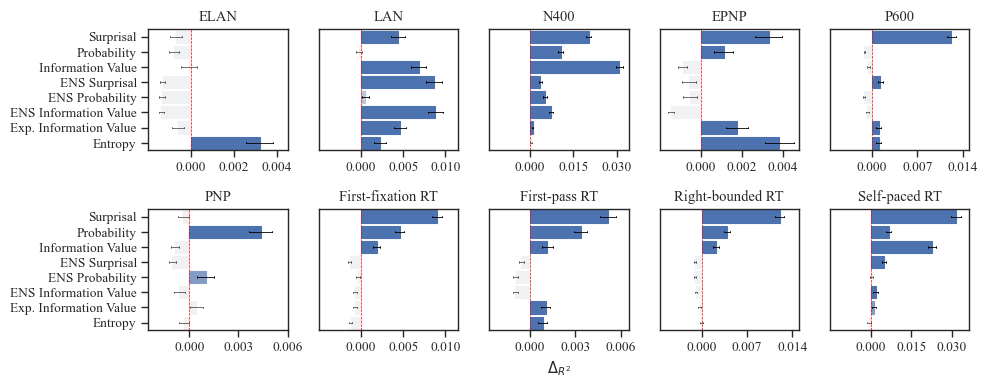

In [340]:
# Plot style settings
sns.set_theme(style="ticks", context="paper", font_scale=1.1)
sns.set_style("ticks", {'font.family': 'Times New Roman'})

# Use four colors for the four p-value ranges: p < 0.0001, p < 0.001, p < 0.01, p > 0.01
palette = sns.color_palette("light:b", 10)

# Collect results only for relevant predicted variables
relevant_y = list(y_labels_erp.keys()) + list(y_labels_rt.keys())
results_fig5 = results_control_baseline_df[results_control_baseline_df.y.isin(relevant_y)] 


# Plot:
# The red dashed line corresponds to the regressor with baseline predictors. 
# Error bars represent 95% confidence intervals. 
# Color codes for p-values: p < 0.0001 (darkest), p < 0.001, p < 0.01, p > 0.01 (lightest).
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, y in enumerate(list(y_labels_erp.keys()) + list(y_labels_rt.keys())):
    plot_data = results_fig5[results_fig5.y == y]
    # sort by metric
    # plot_data.metric = pd.Categorical(plot_data.metric, categories=responsive+anticipatory, ordered=True)
    # plot_data = plot_data.sort_values('metric')

    ax = sns.barplot(
        x='delta_rsquared_test', 
        y='metric', 
        # hue='nsamples',
        data=plot_data, 
        errorbar=("ci", 95),
        capsize=.1,
        err_kws={'linewidth': 0.6, 'color': 'black'},
        ax=axes[i//5, i%5],
        label='$\Delta_{R^2}$' if i == 0 else None,
        width=0.8,
        legend=False,
    )
    if y == 'ELAN':
        ax.set_xlim(-0.002, 0.0045)
        ax.set_xticks(np.arange(0, 0.0046, 0.002))
    elif y == 'LAN':
        ax.set_xlim(-0.005, 0.0115)
        ax.set_xticks(np.arange(0, 0.011, 0.005))
    elif y == 'N400':
        ax.set_xlim(-0.014, 0.034)
        ax.set_xticks(np.arange(0, 0.0341, 0.015))
    elif y == 'EPNP':
        ax.set_xlim(-0.002, 0.0048)
        ax.set_xticks(np.arange(0, 0.0046, 0.002))
    elif y == 'P600':
        ax.set_xlim(-0.0065, 0.015)
        ax.set_xticks(np.arange(0, 0.0151, 0.007))
    elif y == 'PNP':
        ax.set_xlim(-0.0025, 0.006)
        ax.set_xticks(np.arange(0, 0.0061, 0.003))
    elif y == 'RTfirstfix':
        ax.set_xlim(-0.005, 0.0115)
        ax.set_xticks(np.arange(0, 0.011, 0.005))
    elif y == 'RTfirstpass':
        ax.set_xlim(-0.0027, 0.0065)
        ax.set_xticks(np.arange(0, 0.0065, 0.003))
    elif y == 'RTrightbound':
        ax.set_xlim(-0.0065, 0.015)
        ax.set_xticks(np.arange(0, 0.0151, 0.007))
    elif y == 'self_paced_reading_time':
        ax.set_xlim(-0.015, 0.0365)
        ax.set_xticks(np.arange(0, 0.0365, 0.015))
        
    # Baseline: draw vertical red dashed line at 0
    ax.axvline(x=0, color='red', linestyle='--', linewidth=0.5, label='Baseline' if i == 0 else None)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(y_labels[y])

    # Remove y ticks for all but the first subplot in each row
    if i % 5 != 0:
        ax.set_yticks([])
    else:
        ax.set_yticklabels([x_labels[m] for m in plot_data.metric.unique()], horizontalalignment='right')

    # Set x labels for the bottom row
    if i == 7:
        ax.set_xlabel('$\Delta_{R^2}$')
    else:
        ax.set_xlabel('')
    
    # Color code for p-values
    x_labels_list = list(plot_data.metric.unique())
    for j, bar in enumerate(ax.patches):
        metric_j = x_labels[x_labels_list[j]]
        y_label = y_labels[y]
        pval = pvals_baseline[(y_label, metric_j)]
        if pval < 0.0001:
            bar.set_color(palette[-1])
        elif pval < 0.001:
            bar.set_color(palette[-4])
        elif pval < 0.01:
            bar.set_color(palette[-7])
        else:
            bar.set_color(palette[-10])
            ax.lines[j].set_alpha(0.65)

# Legend
# custom_lines = [Line2D([0], [0], color='red', linestyle='--', lw=1),
#                 Line2D([0], [0], color=palette[-1], lw=8),
#                 Line2D([0], [0], color=palette[-4], lw=8),
#                 Line2D([0], [0], color=palette[-7], lw=8),
#                 Line2D([0], [0], color=palette[-10], lw=8)]
# fig.legend(
#     custom_lines, 
#     ['Baseline', 'p < 0.0001', 'p < 0.001', 'p < 0.01', 'p > 0.01'], 
#     loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.075), 
#     fontsize=10, markerscale=1.5, frameon=True, fancybox=True, shadow=True
# )

plt.tight_layout()
plt.savefig(f"{FIGURES_FOLDER}/ols_all_against_baseline_erp_rt_{N_SAMPLES}samples_{N_TOKENS}tokens_{LM}.eps", bbox_inches='tight')
plt.show()


{'surprisal': 'Surprisal',
 'prob': 'Probability',
 'decontextualised': 'Information Value'}

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/3104398225.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_labels_responsive[m] for m in plot_data.metric.unique()], horizontalalignment='right')
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/3104398225.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_labels_responsive[m] for m in plot_data.metric.unique()], horizontalalignment='right')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


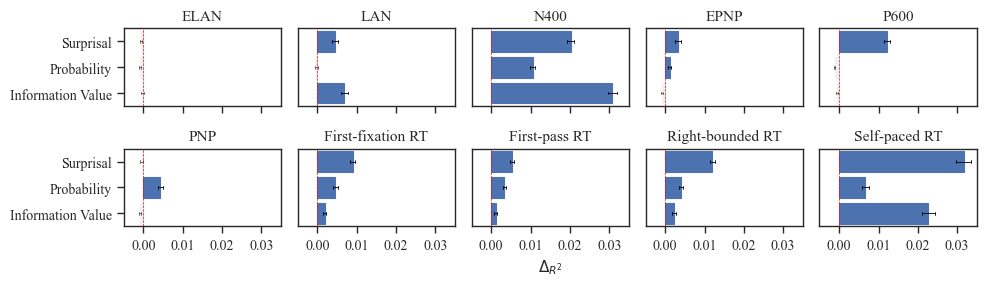

In [338]:
# Redo the plot above but only for responsive measures
# Plot style settings
sns.set_theme(style="ticks", context="paper", font_scale=1.15)
sns.set_style("ticks", {'font.family': 'Times New Roman'})

# Use four colors for the four p-value ranges: p < 0.0001, p < 0.001, p < 0.01, p > 0.01
palette = sns.color_palette("light:b", 10)

# Collect results only for relevant predicted variables
relevant_y = list(y_labels_erp.keys()) + list(y_labels_rt.keys())
results_fig5 = results_control_baseline_df[results_control_baseline_df.y.isin(relevant_y)]
results_fig5 = results_fig5[results_fig5.metric.isin(x_labels_responsive.keys())]
results_fig5.metric = pd.Categorical(results_fig5.metric, categories=x_labels_responsive, ordered=True)
results_fig5 = results_fig5.sort_values('metric')

# Plot:
# The red dashed line corresponds to the regressor with baseline predictors.
# Error bars represent 95% confidence intervals.
# Color codes for p-values: p < 0.0001 (darkest), p < 0.001, p < 0.01, p > 0.01 (lightest).
fig, axes = plt.subplots(2, 5, figsize=(10, 3), sharex=True)

for i, y in enumerate(list(y_labels_erp.keys()) + list(y_labels_rt.keys())):
    plot_data = results_fig5[results_fig5.y == y]
    # sort by metric
    # plot_data.metric = pd.Categorical(plot_data.metric, categories=responsive+anticipatory, ordered=True)
    # plot_data = plot_data.sort_values('metric')

    ax = sns.barplot(
        x='delta_rsquared_test',
        y='metric',
        # hue='nsamples',
        data=plot_data,
        errorbar=("ci", 95),
        capsize=.1,
        err_kws={'linewidth': 0.6, 'color': 'black'},
        ax=axes[i//5, i%5],
        label='$\Delta_{R^2}$' if i == 0 else None,
        width=0.8,
        legend=False,
    )
    ax.set_xlim(-0.005, 0.035)
    ax.set_xticks(np.arange(0, 0.035, 0.01))
    
    # Baseline: draw vertical red dashed line at 0
    ax.axvline(x=0, color='red', linestyle='--', linewidth=0.5, label='Baseline' if i == 0 else None)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(y_labels[y])

    # Remove y ticks for all but the first subplot in each row
    if i % 5 != 0:
        ax.set_yticks([])
    else:
        ax.set_yticklabels([x_labels_responsive[m] for m in plot_data.metric.unique()], horizontalalignment='right')

    # Set x labels for the bottom row
    if i == 7:
        ax.set_xlabel('$\Delta_{R^2}$')
    else:
        ax.set_xlabel('')

    # Color code for p-values
    x_labels_list = list(plot_data.metric.unique())
    for j, bar in enumerate(ax.patches):
        metric_j = x_labels_responsive[x_labels_list[j]]
        y_label = y_labels[y]
        pval = pvals_baseline[(y_label, metric_j)]
        if pval < 0.0001:
            bar.set_color(palette[-1])
        elif pval < 0.001:
            bar.set_color(palette[-4])
        elif pval < 0.01:
            bar.set_color(palette[-7])
        else:
            bar.set_color(palette[-10])
            ax.lines[j].set_alpha(0.65)

plt.tight_layout()
plt.savefig(f"{FIGURES_FOLDER}/ols_responsive_against_baseline_erp_rt_{N_SAMPLES}samples_{N_TOKENS}tokens_{LM}.eps", bbox_inches='tight')
plt.show()


/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/1121616168.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_longlabels_anticipatory[m] for m in plot_data.metric.unique()], horizontalalignment='right')
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/1121616168.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_longlabels_anticipatory[m] for m in plot_data.metric.unique()], horizontalalignment='right')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


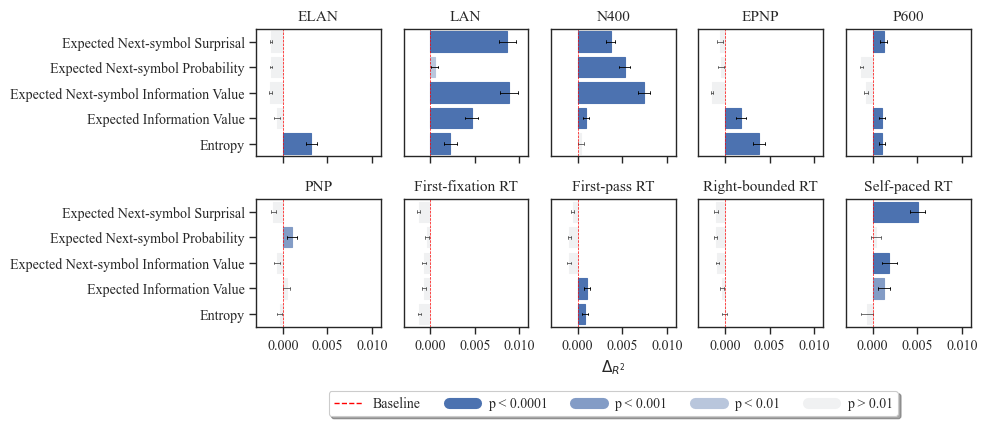

In [359]:
# Redo the plot above but only for anticipatory measures
# Plot style settings
sns.set_theme(style="ticks", context="paper", font_scale=1.15)
sns.set_style("ticks", {'font.family': 'Times New Roman'})

# Use four colors for the four p-value ranges: p < 0.0001, p < 0.001, p < 0.01, p > 0.01
palette = sns.color_palette("light:b", 10)

# Collect results only for relevant predicted variables
relevant_y = list(y_labels_erp.keys()) + list(y_labels_rt.keys())
results_fig5 = results_control_baseline_df[results_control_baseline_df.y.isin(relevant_y)]
results_fig5 = results_fig5[results_fig5.metric.isin(x_labels_anticipatory.keys())]
results_fig5.metric = pd.Categorical(results_fig5.metric, categories=x_labels_anticipatory, ordered=True)
results_fig5 = results_fig5.sort_values('metric')

# Plot:
# The red dashed line corresponds to the regressor with baseline predictors.
# Error bars represent 95% confidence intervals.
# Color codes for p-values: p < 0.0001 (darkest), p < 0.001, p < 0.01, p > 0.01 (lightest).
fig, axes = plt.subplots(2, 5, figsize=(10, 4), sharex=True)

for i, y in enumerate(list(y_labels_erp.keys()) + list(y_labels_rt.keys())):
    plot_data = results_fig5[results_fig5.y == y]
    # sort by metric
    # plot_data.metric = pd.Categorical(plot_data.metric, categories=responsive+anticipatory, ordered=True)
    # plot_data = plot_data.sort_values('metric')

    ax = sns.barplot(
        x='delta_rsquared_test',
        y='metric',
        # hue='nsamples',
        data=plot_data,
        errorbar=("ci", 95),
        capsize=.1,
        err_kws={'linewidth': 0.6, 'color': 'black'},
        ax=axes[i//5, i%5],
        label='$\Delta_{R^2}$' if i == 0 else None,
        width=0.8,
        legend=False,
    )
    ax.set_xlim(-0.003, 0.011)
    ax.set_xticks(np.arange(0, 0.015, 0.005))
    
    # Baseline: draw vertical red dashed line at 0
    ax.axvline(x=0, color='red', linestyle='--', linewidth=0.5, label='Baseline' if i == 0 else None)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(y_labels[y])

    # Remove y ticks for all but the first subplot in each row
    if i % 5 != 0:
        ax.set_yticks([])
    else:
        ax.set_yticklabels([x_longlabels_anticipatory[m] for m in plot_data.metric.unique()], horizontalalignment='right')

    # Set x labels for the bottom row
    if i == 7:
        ax.set_xlabel('$\Delta_{R^2}$')
    else:
        ax.set_xlabel('')
    
    # Color code for p-values
    x_labels_list = list(plot_data.metric.unique())
    for j, bar in enumerate(ax.patches):
        metric_j = x_labels_anticipatory[x_labels_list[j]]
        y_label = y_labels[y]
        pval = pvals_baseline[(y_label, metric_j)]
        if pval < 0.0001:
            bar.set_color(palette[-1])
        elif pval < 0.001:
            bar.set_color(palette[-4])
        elif pval < 0.01:
            bar.set_color(palette[-7])
        else:
            bar.set_color(palette[-10])
            ax.lines[j].set_alpha(0.65)

# Legend
custom_lines = [Line2D([0], [0], color='red', linestyle='--', lw=1),
                Line2D([0], [0], color=palette[-1], lw=8),
                Line2D([0], [0], color=palette[-4], lw=8),
                Line2D([0], [0], color=palette[-7], lw=8),
                Line2D([0], [0], color=palette[-10], lw=8)]
fig.legend(
    custom_lines, 
    ['Baseline', 'p < 0.0001', 'p < 0.001', 'p < 0.01', 'p > 0.01'], 
    loc='lower center', ncol=5, bbox_to_anchor=(0.62, -0.075), 
    fontsize=10, markerscale=1.5, frameon=True, fancybox=True, shadow=True
)

plt.tight_layout()
plt.savefig(f"{FIGURES_FOLDER}/ols_anticipatory_against_baseline_erp_rt_{N_SAMPLES}samples_{N_TOKENS}tokens_{LM}.eps", bbox_inches='tight')
plt.show()


In [255]:
for y in ['N400', 'P600', 'PNP', 'EPNP', 'ELAN', 'LAN']:
    for m1 in ['Probability', 'Surprisal', 'Information Value']:
        for m2 in ['Probability', 'Surprisal', 'Information Value']:
            if m1 == m2:
                continue
            print(f'{y}: {m1} > {m2}   {pvals_cross_metric[(y, m1, m2)]}')
            if pvals_cross_metric[(y, m1, m2)] < 0.01:
                print('^^^^^^^^')


N400: Probability > Surprisal   1.0
N400: Probability > Information Value   1.0
N400: Surprisal > Probability   9.999000099990002e-05
^^^^^^^^
N400: Surprisal > Information Value   1.0
N400: Information Value > Probability   9.999000099990002e-05
^^^^^^^^
N400: Information Value > Surprisal   9.999000099990002e-05
^^^^^^^^
P600: Probability > Surprisal   1.0
P600: Probability > Information Value   0.7318268173182682
P600: Surprisal > Probability   9.999000099990002e-05
^^^^^^^^
P600: Surprisal > Information Value   9.999000099990002e-05
^^^^^^^^
P600: Information Value > Probability   0.2682731726827317
P600: Information Value > Surprisal   1.0
PNP: Probability > Surprisal   0.00029997000299970003
^^^^^^^^
PNP: Probability > Information Value   0.00029997000299970003
^^^^^^^^
PNP: Surprisal > Probability   0.9998000199980002
PNP: Surprisal > Information Value   0.3477652234776522
PNP: Information Value > Probability   0.9998000199980002
PNP: Information Value > Surprisal   0.6523347665

In [369]:
for y in ['First-pass RT']:
    for m1 in ['Entropy', 'ENS Surprisal', 'ENS Probability', 'Exp. Information Value', 'ENS Information Value']:
        print(f'{y}: {m1}   {pvals_baseline[(y, m1)]}')


First-pass RT: Entropy   9.999000099990002e-05
First-pass RT: ENS Surprisal   1.0
First-pass RT: ENS Probability   1.0
First-pass RT: Exp. Information Value   9.999000099990002e-05
First-pass RT: ENS Information Value   1.0


In [365]:
for y in ['First-pass RT']: #, 'Self-paced RT']: #['EPNP']: # 'P600', 'PNP', 'EPNP', 'ELAN', 'LAN']:
    for m1 in ['Entropy', 'ENS Probability', 'ENS Surprisal', 'ENS Information Value', 'Exp. Information Value']:
        for m2 in ['Entropy', 'ENS Probability', 'ENS Surprisal', 'ENS Information Value', 'Exp. Information Value']:
            if m1 == m2:
                continue
            print(f'{y}: {m1} > {m2}   {pvals_cross_metric[(y, m1, m2)]}')
            if pvals_cross_metric[(y, m1, m2)] < 0.01:
                print('^^^^^^^^')


First-pass RT: Entropy > ENS Probability   0.2171782821717828
First-pass RT: Entropy > ENS Surprisal   0.25807419258074193
First-pass RT: Entropy > ENS Information Value   0.1999800019998
First-pass RT: Entropy > Exp. Information Value   0.5385461453854614
First-pass RT: ENS Probability > Entropy   0.7829217078292171
First-pass RT: ENS Probability > ENS Surprisal   0.5638436156384361
First-pass RT: ENS Probability > ENS Information Value   0.49435056494350565
First-pass RT: ENS Probability > Exp. Information Value   0.8102189781021898
First-pass RT: ENS Surprisal > Entropy   0.742025797420258
First-pass RT: ENS Surprisal > ENS Probability   0.43625637436256376
First-pass RT: ENS Surprisal > ENS Information Value   0.4303569643035696
First-pass RT: ENS Surprisal > Exp. Information Value   0.7646235376462354
First-pass RT: ENS Information Value > Entropy   0.8001199880011999
First-pass RT: ENS Information Value > ENS Probability   0.5057494250574942
First-pass RT: ENS Information Value >

In [257]:
for y in ['First-fixation RT', 'First-pass RT', 'Right-bounded RT', 'Self-paced RT']:
    for m1 in ['Probability', 'Surprisal', 'Information Value']:
        for m2 in ['Probability', 'Surprisal', 'Information Value']:
            if m1 == m2:
                continue
            print(f'{y}: {m1} > {m2}   {pvals_cross_metric[(y, m1, m2)]}')
            if pvals_cross_metric[(y, m1, m2)] < 0.01:
                print('^^^^^^^^')


First-fixation RT: Probability > Surprisal   0.9711028897110289
First-fixation RT: Probability > Information Value   0.11158884111588842
First-fixation RT: Surprisal > Probability   0.028997100289971003
First-fixation RT: Surprisal > Information Value   0.00039996000399960006
^^^^^^^^
First-fixation RT: Information Value > Probability   0.8885111488851115
First-fixation RT: Information Value > Surprisal   0.9997000299970003
First-pass RT: Probability > Surprisal   0.792020797920208
First-pass RT: Probability > Information Value   0.16518348165183483
First-pass RT: Surprisal > Probability   0.20807919208079192
First-pass RT: Surprisal > Information Value   0.0365963403659634
First-pass RT: Information Value > Probability   0.8349165083491651
First-pass RT: Information Value > Surprisal   0.9635036496350365
Right-bounded RT: Probability > Surprisal   0.9995000499950005
Right-bounded RT: Probability > Information Value   0.26137386261373863
Right-bounded RT: Surprisal > Probability   0.00

### Figure 7: $\Delta_{R^2}$ of anticipatory metrics for human cloze entropy.

#### Verify significance

In [169]:
for y, m in pvals_baseline.keys():
    if y == 'Cloze entropy' and m in x_labels_anticipatory.values():
        print(f'{y} ~ {m}   p<0.0001 ?   {pvals_baseline[(y, m)] < 0.0001}')

Cloze entropy ~ ENS Surprisal   p<0.0001 ?   True
Cloze entropy ~ ENS Probability   p<0.0001 ?   True
Cloze entropy ~ ENS Information Value   p<0.0001 ?   True
Cloze entropy ~ Exp. Information Value   p<0.0001 ?   True
Cloze entropy ~ Entropy   p<0.0001 ?   True


/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/2475553250.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_longlabels_anticipatory[m] for m in results_fig7.metric.unique()], rotation=0, ha='right', va='center')


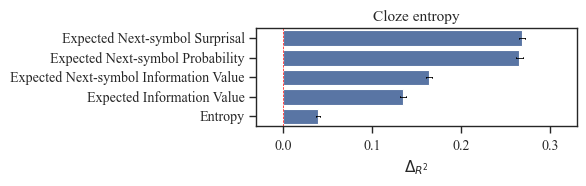

In [335]:
# Plot style settings
sns.set_theme(style='ticks', context='paper', font_scale=1.15)
sns.set_style("ticks", {'font.family': 'Times New Roman'})

# Use the same color for all measures, as all of them show significant predictive power (p < 0.0001)
color = sns.color_palette("light:b", 10)[-1]

# Collect results only for relevant predicted variables and predictors
results_fig7 = results_control_baseline_df[results_control_baseline_df.y == 'entropy']
results_fig7 = results_fig7[results_fig7.metric.isin(x_longlabels_anticipatory.keys())]
results_fig7.metric = pd.Categorical(results_fig7.metric, categories=x_longlabels_anticipatory, ordered=True)
results_fig7 = results_fig7.sort_values('metric')

# Plot:
# The red dashed line corresponds to the regressor with baseline predictors.
# Error bars represent 95% confidence intervals.
# Same color for all measures, as all of them show significant predictive power (p < 0.0001).
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharey=True, sharex=True)

sns.barplot(
    data=results_fig7, 
    y='metric', 
    x='delta_rsquared_test', 
    ax=ax, 
    errorbar=('ci', 95),
    dodge=False, 
    err_kws={'linewidth': 0.6, 'color': 'black'},
    capsize=0.05,
    legend=False,
    label=r'$\Delta_{R^2}$',
    color=color,
)
ax.set_xlabel(r'$\Delta_{R^2}$')
ax.set_ylabel('')
ax.set_yticklabels([x_longlabels_anticipatory[m] for m in results_fig7.metric.unique()], rotation=0, ha='right', va='center')
ax.set_title(y_labels['entropy'])

# Prettify plot: set x limits and ticks
ax.set_xlim(-0.03, 0.33)
ax.set_xticks(np.arange(-0.0, 0.31, 0.1))

# Baseline: add vertical red dashed line at 0
ax.axvline(0, color='red', linestyle='--', linewidth=0.5, label='Baseline')

plt.tight_layout()
plt.savefig(f"{FIGURES_FOLDER}/anticipatory_entropy_{N_SAMPLES}samples_{N_TOKENS}tokens_{LM}.eps", bbox_inches='tight')
plt.show()


In [273]:
for y in ['Cloze entropy']:
    for m1 in x_labels_anticipatory.values():
        for m2 in x_labels_anticipatory.values():
            if m1 == m2:
                continue
            print(f'{y}: {m1} > {m2}   {pvals_cross_metric[(y, m1, m2)]}')
            if pvals_cross_metric[(y, m1, m2)] < 0.01:
                print('^^^^^^^^')


Cloze entropy: ENS Surprisal > ENS Probability   0.1484851514848515
Cloze entropy: ENS Surprisal > ENS Information Value   9.999000099990002e-05
^^^^^^^^
Cloze entropy: ENS Surprisal > Exp. Information Value   9.999000099990002e-05
^^^^^^^^
Cloze entropy: ENS Surprisal > Entropy   9.999000099990002e-05
^^^^^^^^
Cloze entropy: ENS Probability > ENS Surprisal   0.8516148385161484
Cloze entropy: ENS Probability > ENS Information Value   9.999000099990002e-05
^^^^^^^^
Cloze entropy: ENS Probability > Exp. Information Value   9.999000099990002e-05
^^^^^^^^
Cloze entropy: ENS Probability > Entropy   9.999000099990002e-05
^^^^^^^^
Cloze entropy: ENS Information Value > ENS Surprisal   1.0
Cloze entropy: ENS Information Value > ENS Probability   1.0
Cloze entropy: ENS Information Value > Exp. Information Value   9.999000099990002e-05
^^^^^^^^
Cloze entropy: ENS Information Value > Entropy   9.999000099990002e-05
^^^^^^^^
Cloze entropy: Exp. Information Value > ENS Surprisal   1.0
Cloze entropy

## Baseline regressor: control variables + [entropy|surprisal]

### Load cross-validation results

In [370]:
results_surp_ent_baseline_df = pd.read_csv(f"{CROSSVAL_RESULTS_FOLDER}/surprisal_entropy_baseline_{LM_}_temp1_0_{N_SAMPLES}samples_{N_TOKENS}tokens_100x10fold.csv")

# Fill in missing values for exact metrics
results_surp_ent_baseline_df.nsamples = results_surp_ent_baseline_df.nsamples.fillna("")
results_surp_ent_baseline_df.ntokens = results_surp_ent_baseline_df.ntokens.fillna("")
results_surp_ent_baseline_df.temperature = results_surp_ent_baseline_df.temperature.fillna("")

# Consider only cross-validation results
results_surp_ent_baseline_df = results_surp_ent_baseline_df[results_surp_ent_baseline_df.fold != 'full']

# Consider only results for N_SAMPLES (when measure requires MC sampling)
results_surp_ent_baseline_df = results_surp_ent_baseline_df[results_surp_ent_baseline_df.nsamples.isin(['', N_SAMPLES])]

# Reorder columns
results_surp_ent_baseline_df = results_surp_ent_baseline_df[results_surp_ent_baseline_df.metric.isin(x_labels.keys())]
results_surp_ent_baseline_df = results_surp_ent_baseline_df[results_surp_ent_baseline_df.y.isin(y_labels.keys())]
results_surp_ent_baseline_df.metric = pd.Categorical(results_surp_ent_baseline_df.metric, categories=x_labels, ordered=True)
results_surp_ent_baseline_df = results_surp_ent_baseline_df.sort_values('metric')


### Significance testing: permutation tests

In [373]:
# Statistic
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)


# Permutation tests between R^2 of target vs. baseline regressors
pvals_baseline = {}
for y_k, y_v in y_labels.items():
    for m_k, m_v in x_labels.items():

        # Entropy and surprisal are not considered as target regressors because they are baseline predictors here
        if m_k in ['surprisal', 'entropy']:
            continue

        # Target regressor's R^2 (on the test set, across CV folds and random seeds)
        rsquared_target = results_surp_ent_baseline_df[
            (results_surp_ent_baseline_df.y == y_k) & (results_surp_ent_baseline_df.metric == m_k)
        ].rsquared_test.to_numpy()

        # Delta R^2 of target regressor vs. baseline (on the test set, across CV folds and random seeds)
        delta_rsquared = results_surp_ent_baseline_df[
            (results_surp_ent_baseline_df.y == y_k) & (results_surp_ent_baseline_df.metric == m_k)
        ].delta_rsquared_test.to_numpy()

        # Baseline regressor's R^2 (on the test set, across CV folds and random seeds)
        baseline_rsquared = rsquared_target - delta_rsquared
        
        # Permutation test
        # Null hypothesis: the target regressor's R^2 is not greater than the baseline regressor's R^2
        # Alternative hypothesis: the target regressor's R^2 is greater than the baseline regressor's R^2
        result = stats.permutation_test(
            (rsquared_target, baseline_rsquared), 
            statistic, vectorized=True, n_resamples=N_PERMUTATIONS, alternative='greater', permutation_type='samples', random_state=0
        )
        pvals_baseline[(y_v, m_v)] = result.pvalue


# Permutation tests between R^2 of target regressors
pvals_cross_metric = {}
for y_k, y_v in y_labels.items():
    for m1_k, m1_v in x_labels.items():
        for m2_k, m2_v in x_labels.items():
            
            # Entropy and surprisal are not considered as target regressors because they are baseline predictors here
            if m1_k == m2_k or m1_k in ['surprisal', 'entropy'] or m2_k in ['surprisal', 'entropy']:
                continue

            # R^2 of first target regressor (on the test set, across CV folds and random seeds)
            rsquared_m1 = results_surp_ent_baseline_df[
                (results_surp_ent_baseline_df.y == y_k) & (results_surp_ent_baseline_df.metric == m1_k)
            ].rsquared_test.to_numpy()
            
            # R^2 of second target regressor (on the test set, across CV folds and random seeds)
            rsquared_m2 = results_surp_ent_baseline_df[
                (results_surp_ent_baseline_df.y == y_k) & (results_surp_ent_baseline_df.metric == m2_k)
            ].rsquared_test.to_numpy()

            # Permutation test
            # Null hypothesis: the first target regressor's R^2 is not greater than the second target regressor's R^2
            # Alternative hypothesis: the first target regressor's R^2 is greater than the second target regressor's R^2
            result = stats.permutation_test(
                (rsquared_m1, rsquared_m2), 
                statistic, vectorized=True, n_resamples=N_PERMUTATIONS, alternative='greater', permutation_type='samples', random_state=0
            )
            pvals_cross_metric[(y_v, m1_v, m2_v)] = result.pvalue


/Users/mario/Library/Mobile Documents/com~apple~CloudDocs/mario/code/generalized-surprisal/.venv/lib/python3.9/site-packages/scipy/stats/_resampling.py:1114: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


### _Figure 8_: Difference in $\Delta_{R_2}$ of responsive measures with respect to surprisal for ERPs and RTs

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/1090405444.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_labels[m] for m in relevant_metrics], horizontalalignment='right')
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/1090405444.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_labels[m] for m in relevant_metrics], horizontalalignment='right')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


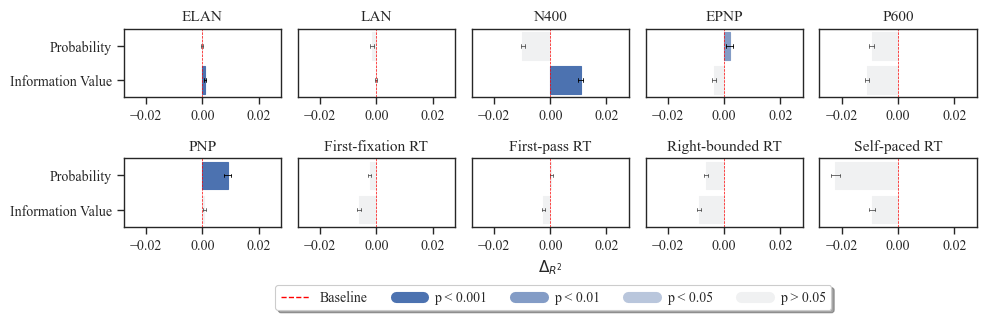

In [385]:
# Plot style settings
sns.set_theme(style="ticks", context="paper", font_scale=1.15)
sns.set_style("ticks", {'font.family': 'Times New Roman'})

# Use four colors for the four p-value ranges: p < 0.001, p < 0.01, p < 0.05, p > 0.05
palette = sns.color_palette("light:b", 10)

# Collect results only for relevant predicted variables
relevant_y = list(y_labels_erp.keys()) + list(y_labels_rt.keys())
relevant_metrics = ['prob', 'decontextualised']    
results_fig8 = results_surp_ent_baseline_df[results_surp_ent_baseline_df.y.isin(relevant_y)]
results_fig8 = results_fig8[results_fig8.metric.isin(relevant_metrics)]
results_fig8.metric = pd.Categorical(results_fig8.metric, categories=relevant_metrics, ordered=True)
results_fig8 = results_fig8.sort_values('metric')

# Plot:
# The red dashed line corresponds to the regressor with baseline predictors.
# Error bars represent 95% confidence intervals.
# Color codes for p-values: p < 0.001 (darkest), p < 0.01, p < 0.05, p > 0.05 (lightest).
fig, axes = plt.subplots(2, 5, figsize=(10, 3))

for i, y in enumerate(list(y_labels_erp.keys()) + list(y_labels_rt.keys())):
    plot_data = results_fig8[results_fig8.y == y]

    ax = sns.barplot(
        x='delta_rsquared_test', 
        y='metric', 
        data=plot_data, 
        errorbar=("ci", 95),
        capsize=.1,
        err_kws={'linewidth': 0.6, 'color': 'black'},
        ax=axes[i//5, i%5],
        label='$\Delta_{R^2}$ target + surprisal' if i == 0 else '',
        legend=False
    )
    
    # Baseline: draw vertical red dashed line at 0
    ax.axvline(x=0, color='red', linestyle='--', linewidth=0.5, label='Next-word entropy + surprisal' if i == 0 else '')

    ax.set_xlabel(r'$\Delta_{R^2}$' if i == 7 else '')
    ax.set_ylabel('')
    ax.set_title(y_labels[y])
    ax.set_xlim(-0.028, 0.028)

    # Remove y ticks for all but the first subplot in each row
    if i % 5 != 0:
        ax.set_yticks([])
    else:
        ax.set_yticklabels([x_labels[m] for m in relevant_metrics], horizontalalignment='right')

    # Color code bars based on p-values
    x_labels_list = list(plot_data.metric.unique())
    for j, bar in enumerate(ax.patches):
        metric_j = x_labels[x_labels_list[j]]
        y_label = y_labels[y]
        pval = pvals_baseline[(y_label, metric_j)]
        if pval < 0.0001:
            bar.set_color(palette[-1])
        elif pval < 0.001:
            bar.set_color(palette[-4])
        elif pval < 0.01:
            bar.set_color(palette[-7])
        else:
            bar.set_color(palette[-10])
            ax.lines[j].set_alpha(0.65)


# Legend
custom_lines = [Line2D([0], [0], color='red', linestyle='--', lw=1),
                Line2D([0], [0], color=palette[-1], lw=8),
                Line2D([0], [0], color=palette[-4], lw=8),
                Line2D([0], [0], color=palette[-7], lw=8),
                Line2D([0], [0], color=palette[-10], lw=8)]
fig.legend(
    custom_lines, 
    ['Baseline', 'p < 0.001', 'p < 0.01', 'p < 0.05', 'p > 0.05'], 
    loc='lower center', ncol=5, bbox_to_anchor=(0.56, -0.08), 
    fontsize=10, markerscale=1.5, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig(f'figures/ols_against_surprisal_erp_rt_{N_SAMPLES}samples_{N_TOKENS}tokens_{LM}.eps', bbox_inches='tight')
plt.show()


### _Figure 9_: Difference in $\Delta_{R_2}$ of anticipatory measures with respect to entropy for ERPs and RTs

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/773156393.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_longlabels_anticipatory[m] for m in relevant_metrics], horizontalalignment='right')
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_70535/773156393.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x_longlabels_anticipatory[m] for m in relevant_metrics], horizontalalignment='right')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


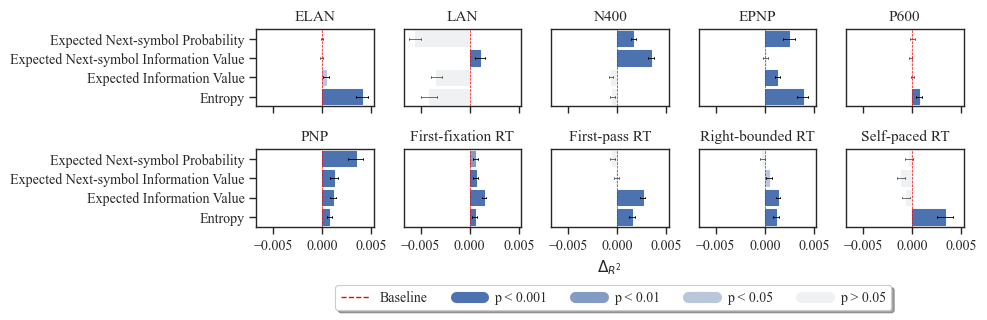

In [381]:
# Plot style settings
sns.set_theme(style="ticks", context="paper", font_scale=1.15)
sns.set_style("ticks", {'font.family': 'Times New Roman'})

# Use four colors for the four p-value ranges: p < 0.001, p < 0.01, p < 0.05, p > 0.05
palette = sns.color_palette("light:b", 10)

# Collect results only for relevant predicted variables
relevant_y = list(y_labels_erp.keys()) + list(y_labels_rt.keys())
relevant_metrics = [m for m in x_labels_anticipatory if m != 'entropy']

# subtract from list

results_fig9 = results_surp_ent_baseline_df[results_surp_ent_baseline_df.y.isin(relevant_y)]
results_fig9 = results_fig9[results_fig9.metric.isin(relevant_metrics)]
results_fig9.metric = pd.Categorical(results_fig9.metric, categories=relevant_metrics, ordered=True)
results_fig9 = results_fig9.sort_values('metric')

# Plot:
# The red dashed line corresponds to the regressor with baseline predictors.
# Error bars represent 95% confidence intervals.
# Color codes for p-values: p < 0.001 (darkest), p < 0.01, p < 0.05, p > 0.05 (lightest).
fig, axes = plt.subplots(2, 5, figsize=(10, 3), sharex=True)

for i, y in enumerate(list(y_labels_erp.keys()) + list(y_labels_rt.keys())):
    plot_data = results_fig9[results_fig9.y == y]

    ax = sns.barplot(
        x='delta_rsquared_test', 
        y='metric', 
        data=plot_data, 
        errorbar=("ci", 95),
        capsize=.1,
        err_kws={'linewidth': 0.6, 'color': 'black'},
        ax=axes[i//5, i%5],
        label='$\Delta_{R^2}$ target + surprisal' if i == 0 else '',
        legend=False
    )
    
    # Baseline: draw vertical red dashed line at 0
    ax.axvline(x=0, color='red', linestyle='--', linewidth=0.5, label='Next-word entropy + surprisal' if i == 0 else '')

    ax.set_xlabel(r'$\Delta_{R^2}$' if i == 7 else '')
    ax.set_ylabel('')
    ax.set_title(y_labels[y])
    # if y in y_labels_erp:
    #     ax.set_xlim(-0.007, 0.007)
    # else:
    #     ax.set_xlim(-0.005, 0.005)
    ax.set_xticks(np.arange(-0.005, 0.006, 0.005))

    # Remove y ticks for all but the first subplot in each row
    if i % 5 != 0:
        ax.set_yticks([])
    else:
        ax.set_yticklabels([x_longlabels_anticipatory[m] for m in relevant_metrics], horizontalalignment='right')

    # Color code bars based on p-values
    x_labels_list = list(plot_data.metric.unique())
    for j, bar in enumerate(ax.patches):
        metric_j = x_labels[x_labels_list[j]]
        y_label = y_labels[y]
        pval = pvals_baseline[(y_label, metric_j)]
        if pval < 0.0001:
            bar.set_color(palette[-1])
        elif pval < 0.001:
            bar.set_color(palette[-4])
        elif pval < 0.01:
            bar.set_color(palette[-7])
        else:
            bar.set_color(palette[-10])
            ax.lines[j].set_alpha(0.65)


# Legend
custom_lines = [Line2D([0], [0], color='red', linestyle='--', lw=1),
                Line2D([0], [0], color=palette[-1], lw=8),
                Line2D([0], [0], color=palette[-4], lw=8),
                Line2D([0], [0], color=palette[-7], lw=8),
                Line2D([0], [0], color=palette[-10], lw=8)]
fig.legend(
    custom_lines, 
    ['Baseline', 'p < 0.001', 'p < 0.01', 'p < 0.05', 'p > 0.05'], 
    loc='lower center', ncol=5, bbox_to_anchor=(0.62, -0.08), 
    fontsize=10, markerscale=1.5, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig(f'figures/ols_against_entropy_erp_rt_{N_SAMPLES}samples_{N_TOKENS}tokens_{LM}.eps', bbox_inches='tight')
plt.show()


## Baseline regressor: control variables + surprisal 
(ANTICIPATORY MEASURES ONLY)

### Load cross-validation results

In [17]:
results_surp_baseline_df = pd.read_csv(f"{CROSSVAL_RESULTS_FOLDER}/surprisal_baseline_{LM_}_temp1_0_{N_SAMPLES}samples_{N_TOKENS}tokens_100x10fold.csv")

# Fill in missing values for exact metrics
results_surp_baseline_df.nsamples = results_surp_baseline_df.nsamples.fillna("")
results_surp_baseline_df.ntokens = results_surp_baseline_df.ntokens.fillna("")
results_surp_baseline_df.temperature = results_surp_baseline_df.temperature.fillna("")

# Consider only cross-validation results
results_surp_baseline_df = results_surp_baseline_df[results_surp_baseline_df.fold != 'full']

# Consider only results for N_SAMPLES (when measure requires MC sampling)
results_surp_baseline_df = results_surp_baseline_df[results_surp_baseline_df.nsamples.isin(['', N_SAMPLES])]

# Reorder columns
results_surp_baseline_df = results_surp_baseline_df[results_surp_baseline_df.metric.isin(x_labels.keys())]
results_surp_baseline_df = results_surp_baseline_df[results_surp_baseline_df.y.isin(y_labels.keys())]
results_surp_baseline_df.metric = pd.Categorical(results_surp_baseline_df.metric, categories=x_labels, ordered=True)
results_surp_baseline_df = results_surp_baseline_df.sort_values('metric')


### Significance testing: permutation tests

In [19]:
# Statistic
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)


# Permutation tests between R^2 of target vs. baseline regressors
pvals_baseline = {}
for y_k, y_v in y_labels.items():
    for m_k, m_v in x_labels_anticipatory.items():

        print(y_k, m_k)

        # Target regressor's R^2 (on the test set, across CV folds and random seeds)
        rsquared_target = results_surp_baseline_df[
            (results_surp_baseline_df.y == y_k) & (results_surp_baseline_df.metric == m_k)
        ].rsquared_test.to_numpy()

        # Delta R^2 of target regressor vs. baseline (on the test set, across CV folds and random seeds)
        delta_rsquared = results_surp_baseline_df[
            (results_surp_baseline_df.y == y_k) & (results_surp_baseline_df.metric == m_k)
        ].delta_rsquared_test.to_numpy()

        # Baseline regressor's R^2 (on the test set, across CV folds and random seeds)
        baseline_rsquared = rsquared_target - delta_rsquared
        
        # Permutation test
        # Null hypothesis: the target regressor's R^2 is not greater than the baseline regressor's R^2
        # Alternative hypothesis: the target regressor's R^2 is greater than the baseline regressor's R^2
        result = stats.permutation_test(
            (rsquared_target, baseline_rsquared), 
            statistic, vectorized=True, n_resamples=N_PERMUTATIONS, alternative='greater', permutation_type='samples', random_state=0
        )
        pvals_baseline[(y_v, m_v)] = result.pvalue


# Permutation tests between R^2 of target regressors
pvals_cross_metric = {}
for y_k, y_v in y_labels.items():
    for m1_k, m1_v in x_labels.items():
        for m2_k, m2_v in x_labels.items():
            
            if m1_k == m2_k:
                continue

            # R^2 of first target regressor (on the test set, across CV folds and random seeds)
            rsquared_m1 = results_surp_baseline_df[
                (results_surp_baseline_df.y == y_k) & (results_surp_baseline_df.metric == m1_k)
            ].rsquared_test.to_numpy()
            
            # R^2 of second target regressor (on the test set, across CV folds and random seeds)
            rsquared_m2 = results_surp_baseline_df[
                (results_surp_baseline_df.y == y_k) & (results_surp_baseline_df.metric == m2_k)
            ].rsquared_test.to_numpy()

            # Permutation test
            # Null hypothesis: the first target regressor's R^2 is not greater than the second target regressor's R^2
            # Alternative hypothesis: the first target regressor's R^2 is greater than the second target regressor's R^2
            result = stats.permutation_test(
                (rsquared_m1, rsquared_m2), 
                statistic, vectorized=True, n_resamples=N_PERMUTATIONS, alternative='greater', permutation_type='samples', random_state=0
            )
            pvals_cross_metric[(y_v, m1_v, m2_v)] = result.pvalue


cloze_p_smoothed entropy


ValueError: each sample in `data` must contain two or more observations along `axis`.